## Import all libraries and Dataset

In [1]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.gridspec as gridspec
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import joblib

c:\Users\pc\Documents\Bells COLENG\Dr Amole\Intelligent Energy Management\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import the Data
data= pd.read_excel('data.xlsx')
data.head()

,Datetime,SANGO,TOWER,FSM,AMJE,SUMO,ESTATE,IDIROKO,IJAGBA,TOLLGATE,AARTI,ARRACHID,QUALITEC
0,2024-01-01 01:00:00.000,869238,310417.0,135989.0,14421.8,69226.0,659772.0,246067.0,182666.0,310269.0,10040.0,13669.0,4375.8
1,2024-01-01 02:00:00.000,869238,310419.0,135992.0,14421.8,69226.0,659772.0,246078.0,182673.0,310269.0,10040.0,13671.3,4376.0
2,2024-01-01 03:00:00.005,869238,310420.0,135995.0,14421.8,69227.0,659772.0,246091.0,182680.0,310269.0,10040.0,13673.6,4376.1
3,2024-01-01 04:00:00.010,869238,310421.0,135997.0,14421.8,69227.0,659772.0,246102.0,182687.0,310269.0,10040.0,13676.0,4376.3
4,2024-01-01 05:00:00.015,869238,310422.0,135999.0,14421.8,69227.0,659772.0,246102.0,182694.0,310269.0,10040.0,13678.7,4376.4


## Preprocessing

In [3]:
data.columns = [c.strip().lower() for c in data.columns]
data

,datetime,sango,tower,fsm,amje,sumo,estate,idiroko,ijagba,tollgate,aarti,arrachid,qualitec
0,2024-01-01 01:00:00.000,869238,310417.000000,135989.000000,14421.800000,69226.000000,659772.000000,246067.000000,182666.000000,310269.000000,10040.000000,13669.000000,4375.800000
1,2024-01-01 02:00:00.000,869238,310419.000000,135992.000000,14421.800000,69226.000000,659772.000000,246078.000000,182673.000000,310269.000000,10040.000000,13671.300000,4376.000000
2,2024-01-01 03:00:00.005,869238,310420.000000,135995.000000,14421.800000,69227.000000,659772.000000,246091.000000,182680.000000,310269.000000,10040.000000,13673.600000,4376.100000
3,2024-01-01 04:00:00.010,869238,310421.000000,135997.000000,14421.800000,69227.000000,659772.000000,246102.000000,182687.000000,310269.000000,10040.000000,13676.000000,4376.300000
4,2024-01-01 05:00:00.015,869238,310422.000000,135999.000000,14421.800000,69227.000000,659772.000000,246102.000000,182694.000000,310269.000000,10040.000000,13678.700000,4376.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2024-11-17 20:00:38.610,881472.249458,312270.052080,137192.378484,20964.158875,70115.952195,669185.346146,253443.942662,188498.773909,321233.066400,10908.006514,17279.735909,10113.786603
7724,2024-11-17 21:00:38.615,881997.843671,312593.749659,137308.560023,20944.584818,70078.001194,669044.131777,253376.056943,188246.561307,321472.555918,10912.560105,17272.336160,10113.240837
7725,2024-11-17 22:00:38.620,881892.732907,312243.032465,137241.616614,20939.430260,70074.004056,669432.496187,253660.971134,188636.516099,321190.875790,10919.986855,17264.779473,10116.188441
7726,2024-11-17 23:00:38.625,880950.918212,312284.514909,137235.997267,20931.012353,70096.734061,669271.704987,253569.978386,188514.580505,320955.697646,10912.153296,17287.569474,10112.210624


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data

,datetime,sango,tower,fsm,amje,sumo,estate,idiroko,ijagba,tollgate,aarti,arrachid,qualitec
0,2024-01-01 01:00:00.000,869238,310417.000000,135989.000000,14421.800000,69226.000000,659772.000000,246067.000000,182666.000000,310269.000000,10040.000000,13669.000000,4375.800000
1,2024-01-01 02:00:00.000,869238,310419.000000,135992.000000,14421.800000,69226.000000,659772.000000,246078.000000,182673.000000,310269.000000,10040.000000,13671.300000,4376.000000
2,2024-01-01 03:00:00.005,869238,310420.000000,135995.000000,14421.800000,69227.000000,659772.000000,246091.000000,182680.000000,310269.000000,10040.000000,13673.600000,4376.100000
3,2024-01-01 04:00:00.010,869238,310421.000000,135997.000000,14421.800000,69227.000000,659772.000000,246102.000000,182687.000000,310269.000000,10040.000000,13676.000000,4376.300000
4,2024-01-01 05:00:00.015,869238,310422.000000,135999.000000,14421.800000,69227.000000,659772.000000,246102.000000,182694.000000,310269.000000,10040.000000,13678.700000,4376.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2024-11-17 20:00:38.610,881472.249458,312270.052080,137192.378484,20964.158875,70115.952195,669185.346146,253443.942662,188498.773909,321233.066400,10908.006514,17279.735909,10113.786603
7724,2024-11-17 21:00:38.615,881997.843671,312593.749659,137308.560023,20944.584818,70078.001194,669044.131777,253376.056943,188246.561307,321472.555918,10912.560105,17272.336160,10113.240837
7725,2024-11-17 22:00:38.620,881892.732907,312243.032465,137241.616614,20939.430260,70074.004056,669432.496187,253660.971134,188636.516099,321190.875790,10919.986855,17264.779473,10116.188441
7726,2024-11-17 23:00:38.625,880950.918212,312284.514909,137235.997267,20931.012353,70096.734061,669271.704987,253569.978386,188514.580505,320955.697646,10912.153296,17287.569474,10112.210624


In [5]:
#Convert each feeders from WH to MWH
for col in data.columns[1:]:  # Start from the second column
    data[col] = pd.to_numeric(data[col], errors='coerce') 
    data[col] = data[col] / 1e6
        
data

,datetime,sango,tower,fsm,amje,sumo,estate,idiroko,ijagba,tollgate,aarti,arrachid,qualitec
0,2024-01-01 01:00:00.000,0.869238,0.310417,0.135989,0.014422,0.069226,0.659772,0.246067,0.182666,0.310269,0.010040,0.013669,0.004376
1,2024-01-01 02:00:00.000,0.869238,0.310419,0.135992,0.014422,0.069226,0.659772,0.246078,0.182673,0.310269,0.010040,0.013671,0.004376
2,2024-01-01 03:00:00.005,0.869238,0.310420,0.135995,0.014422,0.069227,0.659772,0.246091,0.182680,0.310269,0.010040,0.013674,0.004376
3,2024-01-01 04:00:00.010,0.869238,0.310421,0.135997,0.014422,0.069227,0.659772,0.246102,0.182687,0.310269,0.010040,0.013676,0.004376
4,2024-01-01 05:00:00.015,0.869238,0.310422,0.135999,0.014422,0.069227,0.659772,0.246102,0.182694,0.310269,0.010040,0.013679,0.004376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2024-11-17 20:00:38.610,0.881472,0.312270,0.137192,0.020964,0.070116,0.669185,0.253444,0.188499,0.321233,0.010908,0.017280,0.010114
7724,2024-11-17 21:00:38.615,0.881998,0.312594,0.137309,0.020945,0.070078,0.669044,0.253376,0.188247,0.321473,0.010913,0.017272,0.010113
7725,2024-11-17 22:00:38.620,0.881893,0.312243,0.137242,0.020939,0.070074,0.669432,0.253661,0.188637,0.321191,0.010920,0.017265,0.010116
7726,2024-11-17 23:00:38.625,0.880951,0.312285,0.137236,0.020931,0.070097,0.669272,0.253570,0.188515,0.320956,0.010912,0.017288,0.010112


In [6]:
# Check for missing values
data.isnull().sum()

datetime     0
sango        2
tower        1
fsm          1
amje        17
sumo         5
estate       2
idiroko      1
ijagba       1
tollgate     1
aarti        1
arrachid     7
qualitec     0
dtype: int64

In [7]:
# Use Linear interpolation to fill missing values
data_clean = data.copy()
data_clean = data_clean.set_index('datetime')
# Interpolate missing values
data_clean = data_clean.interpolate(method='time')
data_clean = data_clean.reset_index()
# Check remaining missing values
data_clean.isnull().sum()

datetime    0
sango       0
tower       0
fsm         0
amje        0
sumo        0
estate      0
idiroko     0
ijagba      0
tollgate    0
aarti       0
arrachid    0
qualitec    0
dtype: int64

In [8]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728 entries, 0 to 7727
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  7728 non-null   datetime64[ns]
 1   sango     7728 non-null   float64       
 2   tower     7728 non-null   float64       
 3   fsm       7728 non-null   float64       
 4   amje      7728 non-null   float64       
 5   sumo      7728 non-null   float64       
 6   estate    7728 non-null   float64       
 7   idiroko   7728 non-null   float64       
 8   ijagba    7728 non-null   float64       
 9   tollgate  7728 non-null   float64       
 10  aarti     7728 non-null   float64       
 11  arrachid  7728 non-null   float64       
 12  qualitec  7728 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 785.0 KB


In [9]:
data_clean.describe()

,datetime,sango,tower,fsm,amje,sumo,estate,idiroko,ijagba,tollgate,aarti,arrachid,qualitec
count,7728,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000,7728.000000
mean,2024-06-10 00:30:19.312500224,0.885172,0.311255,0.137341,0.023083,0.071828,0.669867,0.254312,0.189216,0.324827,0.010680,0.018161,0.007573
min,2024-01-01 01:00:00,0.087254,0.013741,0.135649,0.001313,0.067967,0.067090,0.024830,0.019816,0.306907,0.009856,0.000176,0.000000
25%,2024-03-21 12:45:09.653750016,0.880740,0.311974,0.136940,0.020703,0.069820,0.668692,0.253253,0.188241,0.320896,0.010632,0.017017,0.006419
50%,2024-06-10 00:30:19.312499968,0.881176,0.312146,0.137061,0.020823,0.069919,0.669033,0.253416,0.188383,0.321085,0.010733,0.017135,0.007707
75%,2024-08-29 12:15:28.971249920,0.881861,0.312355,0.137179,0.020946,0.070010,0.669562,0.253657,0.188576,0.321376,0.010830,0.017253,0.008915
max,2024-11-18 00:00:38.630000,8.855578,0.960000,1.137462,0.316125,0.699722,0.686665,2.463770,0.201365,3.238801,0.011000,1.906770,0.010119
std,NaN,0.157729,0.020025,0.011757,0.016514,0.035049,0.013055,0.026549,0.004238,0.054053,0.000240,0.031391,0.001616


## Feature Engineering

In [10]:
data_clean = data_clean.copy()
data_clean['hour'] = data_clean['datetime'].dt.hour
data_clean['day_of_week'] = data_clean['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
data_clean['month'] = data_clean['datetime'].dt.month
data_clean['day'] = data_clean['datetime'].dt.day
data_clean['year'] = data_clean['datetime'].dt.year
data_clean['is_weekend'] = (data_clean['day_of_week'] >= 5).astype(int)

data_clean

,datetime,sango,tower,fsm,amje,sumo,estate,idiroko,ijagba,tollgate,aarti,arrachid,qualitec,hour,day_of_week,month,day,year,is_weekend
0,2024-01-01 01:00:00.000,0.869238,0.310417,0.135989,0.014422,0.069226,0.659772,0.246067,0.182666,0.310269,0.010040,0.013669,0.004376,1,0,1,1,2024,0
1,2024-01-01 02:00:00.000,0.869238,0.310419,0.135992,0.014422,0.069226,0.659772,0.246078,0.182673,0.310269,0.010040,0.013671,0.004376,2,0,1,1,2024,0
2,2024-01-01 03:00:00.005,0.869238,0.310420,0.135995,0.014422,0.069227,0.659772,0.246091,0.182680,0.310269,0.010040,0.013674,0.004376,3,0,1,1,2024,0
3,2024-01-01 04:00:00.010,0.869238,0.310421,0.135997,0.014422,0.069227,0.659772,0.246102,0.182687,0.310269,0.010040,0.013676,0.004376,4,0,1,1,2024,0
4,2024-01-01 05:00:00.015,0.869238,0.310422,0.135999,0.014422,0.069227,0.659772,0.246102,0.182694,0.310269,0.010040,0.013679,0.004376,5,0,1,1,2024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2024-11-17 20:00:38.610,0.881472,0.312270,0.137192,0.020964,0.070116,0.669185,0.253444,0.188499,0.321233,0.010908,0.017280,0.010114,20,6,11,17,2024,1
7724,2024-11-17 21:00:38.615,0.881998,0.312594,0.137309,0.020945,0.070078,0.669044,0.253376,0.188247,0.321473,0.010913,0.017272,0.010113,21,6,11,17,2024,1
7725,2024-11-17 22:00:38.620,0.881893,0.312243,0.137242,0.020939,0.070074,0.669432,0.253661,0.188637,0.321191,0.010920,0.017265,0.010116,22,6,11,17,2024,1
7726,2024-11-17 23:00:38.625,0.880951,0.312285,0.137236,0.020931,0.070097,0.669272,0.253570,0.188515,0.320956,0.010912,0.017288,0.010112,23,6,11,17,2024,1


In [11]:
# 2. Create cyclical features for time variables (preserves cyclical nature)
data_clean['hour_sin'] = np.sin(2 * np.pi * data_clean['hour']/24)
data_clean['hour_cos'] = np.cos(2 * np.pi * data_clean['hour']/24)
data_clean['month_sin'] = np.sin(2 * np.pi * data_clean['month']/12)
data_clean['month_cos'] = np.cos(2 * np.pi * data_clean['month']/12)
data_clean['day_of_week_sin'] = np.sin(2 * np.pi * data_clean['day_of_week']/7)
data_clean['day_of_week_cos'] = np.cos(2 * np.pi * data_clean['day_of_week']/7)

data_clean.isnull().sum()


datetime           0
sango              0
tower              0
fsm                0
amje               0
sumo               0
estate             0
idiroko            0
ijagba             0
tollgate           0
aarti              0
arrachid           0
qualitec           0
hour               0
day_of_week        0
month              0
day                0
year               0
is_weekend         0
hour_sin           0
hour_cos           0
month_sin          0
month_cos          0
day_of_week_sin    0
day_of_week_cos    0
dtype: int64

In [12]:
# Create a list of all columns
all_columns = data_clean.columns.tolist()

# Identify feeder columns (all numeric columns except the engineered features)
time_feature_cols = ['hour', 'day_of_week', 'month', 'day', 'year', 'is_weekend', 
                     'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                     'day_of_week_sin', 'day_of_week_cos']

# First column is datetime, the rest are feeder columns initially
feeder_cols = [col for col in all_columns if col not in ['datetime'] + time_feature_cols]

# Create new column order: datetime, time features, then feeders
new_column_order = ['datetime'] + time_feature_cols + feeder_cols

# Reorder the DataFrame
data_clean = data_clean[new_column_order]

# Verify the new order
data_clean

,datetime,hour,day_of_week,month,day,year,is_weekend,hour_sin,hour_cos,month_sin,...,fsm,amje,sumo,estate,idiroko,ijagba,tollgate,aarti,arrachid,qualitec
0,2024-01-01 01:00:00.000,1,0,1,1,2024,0,0.258819,0.965926,0.5,...,0.135989,0.014422,0.069226,0.659772,0.246067,0.182666,0.310269,0.010040,0.013669,0.004376
1,2024-01-01 02:00:00.000,2,0,1,1,2024,0,0.500000,0.866025,0.5,...,0.135992,0.014422,0.069226,0.659772,0.246078,0.182673,0.310269,0.010040,0.013671,0.004376
2,2024-01-01 03:00:00.005,3,0,1,1,2024,0,0.707107,0.707107,0.5,...,0.135995,0.014422,0.069227,0.659772,0.246091,0.182680,0.310269,0.010040,0.013674,0.004376
3,2024-01-01 04:00:00.010,4,0,1,1,2024,0,0.866025,0.500000,0.5,...,0.135997,0.014422,0.069227,0.659772,0.246102,0.182687,0.310269,0.010040,0.013676,0.004376
4,2024-01-01 05:00:00.015,5,0,1,1,2024,0,0.965926,0.258819,0.5,...,0.135999,0.014422,0.069227,0.659772,0.246102,0.182694,0.310269,0.010040,0.013679,0.004376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,2024-11-17 20:00:38.610,20,6,11,17,2024,1,-0.866025,0.500000,-0.5,...,0.137192,0.020964,0.070116,0.669185,0.253444,0.188499,0.321233,0.010908,0.017280,0.010114
7724,2024-11-17 21:00:38.615,21,6,11,17,2024,1,-0.707107,0.707107,-0.5,...,0.137309,0.020945,0.070078,0.669044,0.253376,0.188247,0.321473,0.010913,0.017272,0.010113
7725,2024-11-17 22:00:38.620,22,6,11,17,2024,1,-0.500000,0.866025,-0.5,...,0.137242,0.020939,0.070074,0.669432,0.253661,0.188637,0.321191,0.010920,0.017265,0.010116
7726,2024-11-17 23:00:38.625,23,6,11,17,2024,1,-0.258819,0.965926,-0.5,...,0.137236,0.020931,0.070097,0.669272,0.253570,0.188515,0.320956,0.010912,0.017288,0.010112


## Exploratory Data Analysis

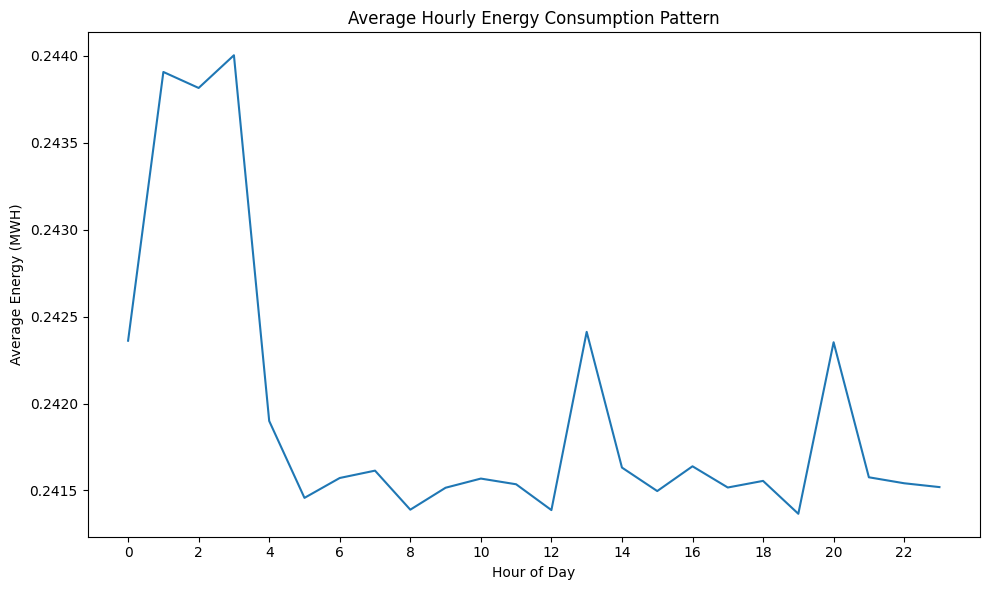

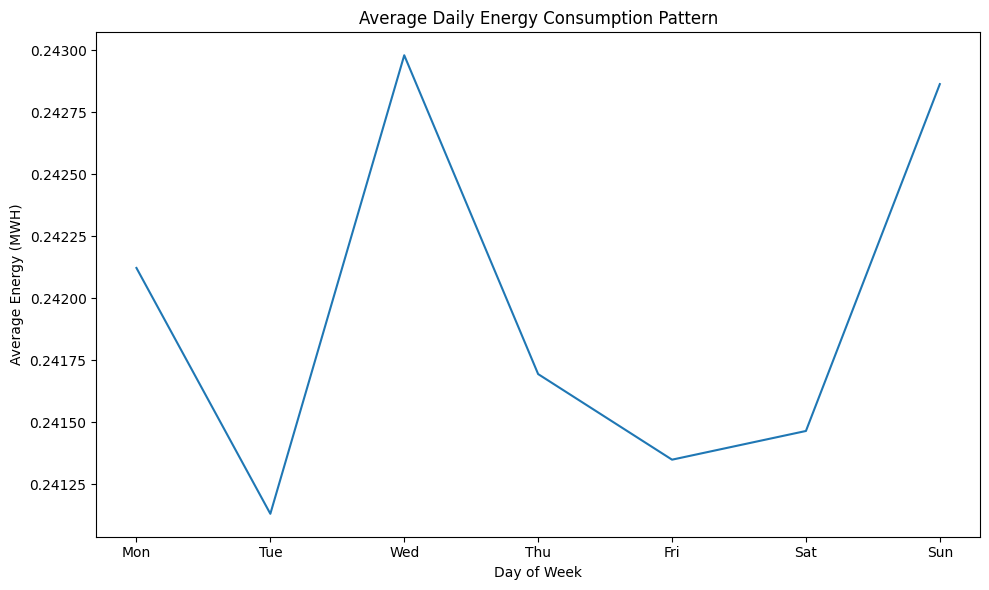

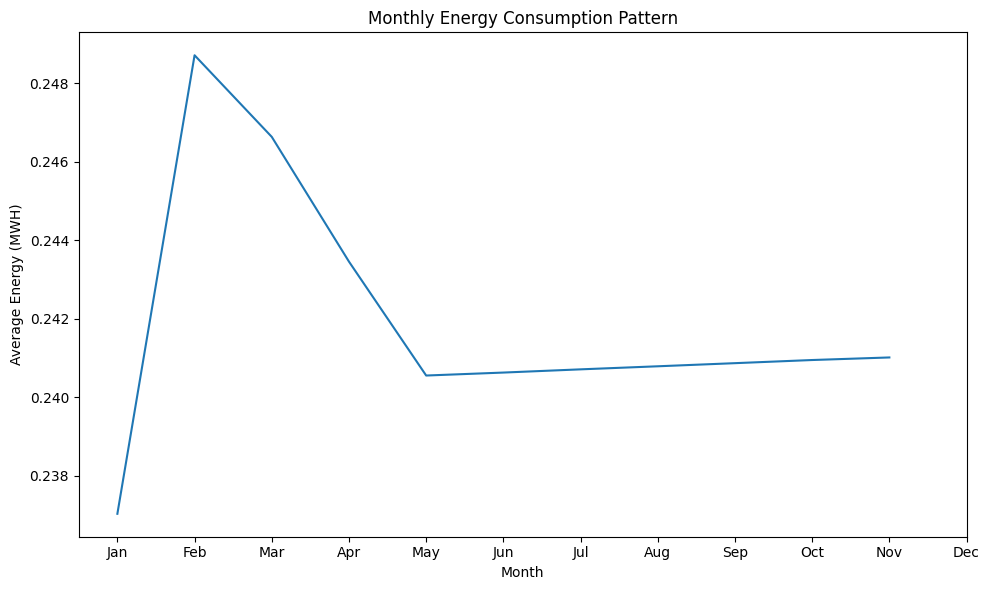

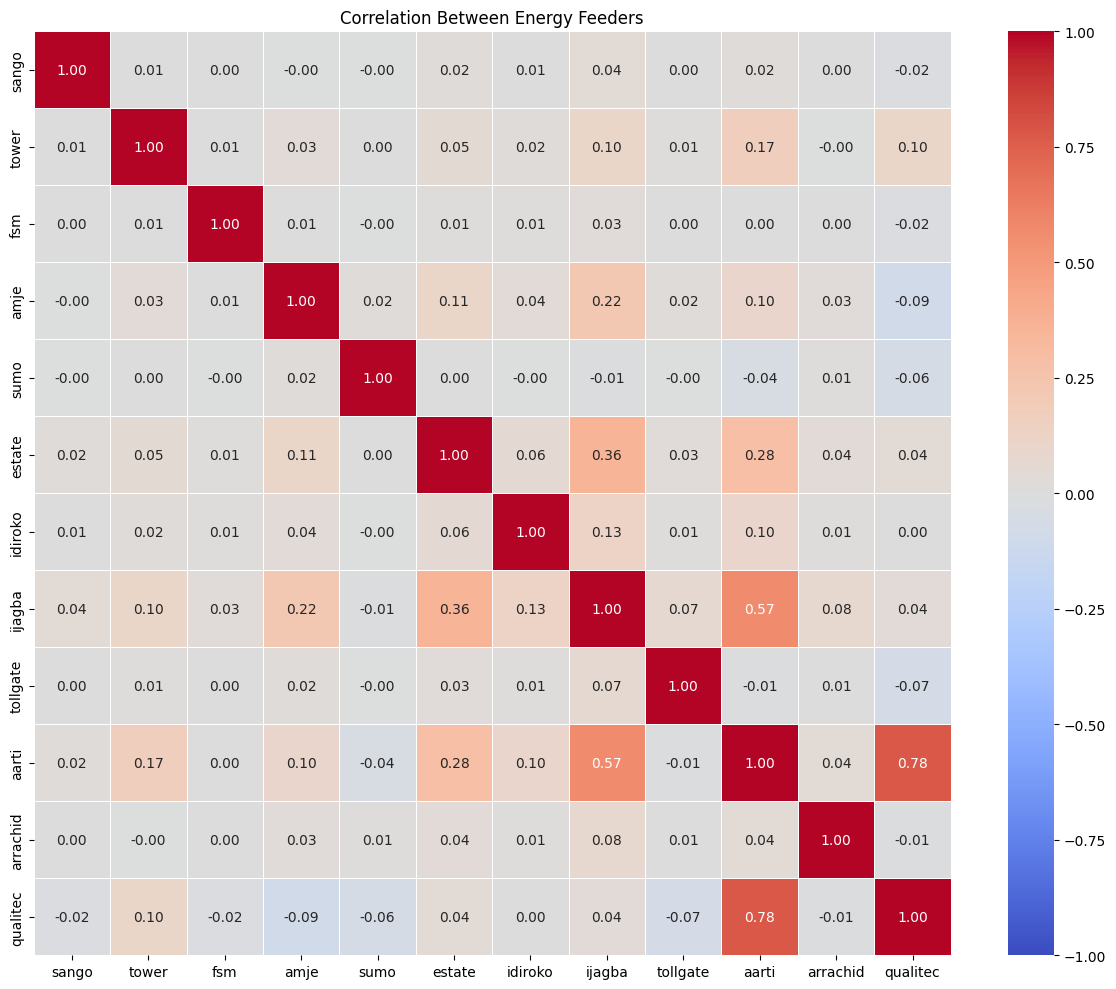

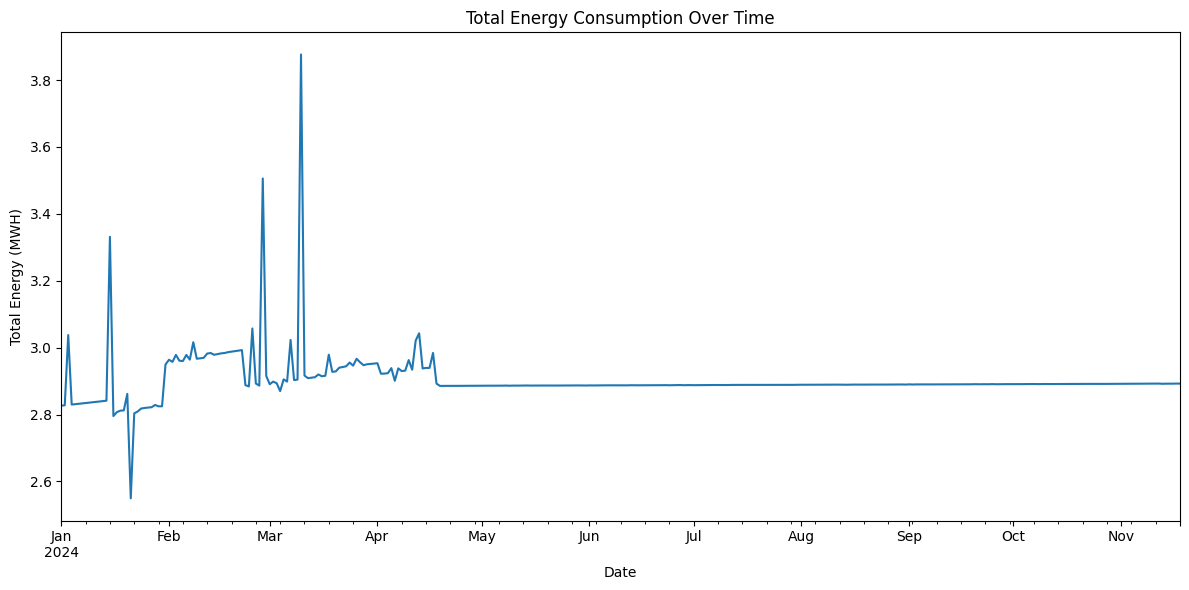

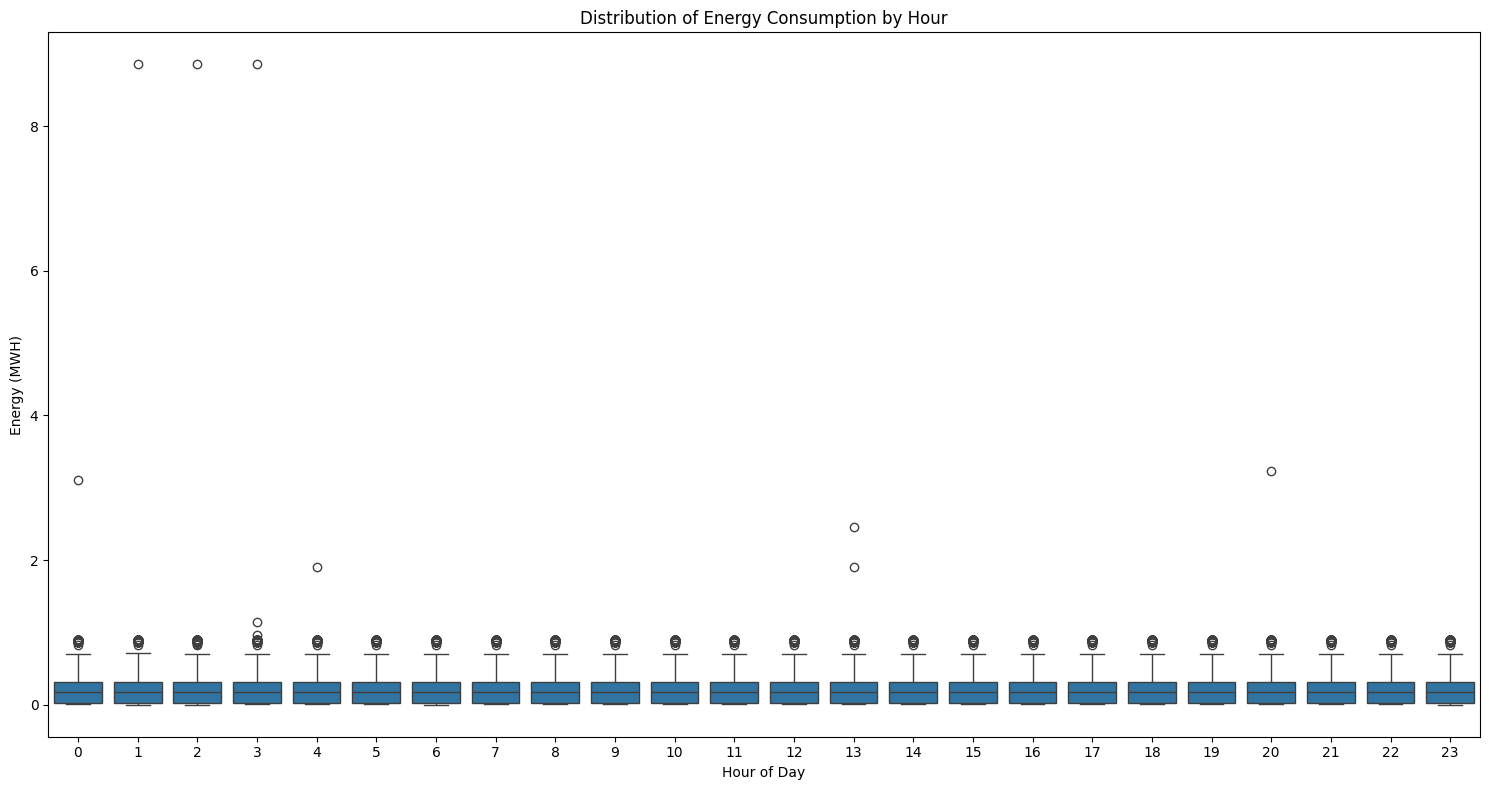

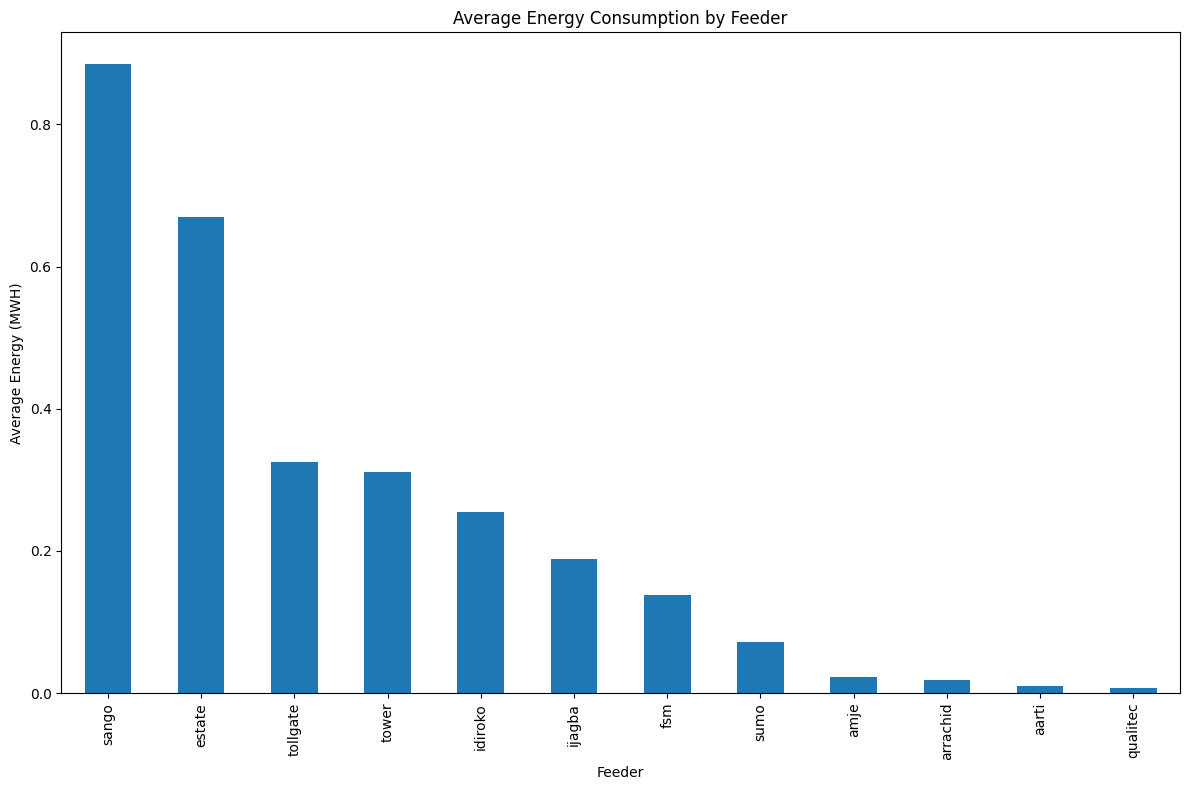

All plots have been saved to the 'energy_plots' folder


In [13]:
# Create a directory for storing plots if it doesn't exist
plot_dir = 'energy_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Create a copy for plotting
plot_data = data_clean.copy()

# 1. Daily consumption patterns by hour
plt.figure(figsize=(10, 6))
hourly_consumption = plot_data.groupby('hour')[feeder_cols].mean()
hourly_consumption.mean(axis=1).plot()
plt.title('Average Hourly Energy Consumption Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy (MWH)')
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'hourly_consumption.png'), dpi=300)
plt.show()

# 2. Weekly patterns by day
plt.figure(figsize=(10, 6))
daily_consumption = plot_data.groupby('day_of_week')[feeder_cols].mean()
daily_consumption.mean(axis=1).plot()
plt.title('Average Daily Energy Consumption Pattern')
plt.xlabel('Day of Week')
plt.ylabel('Average Energy (MWH)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'daily_consumption.png'), dpi=300)
plt.show()

# 3. Monthly seasonal patterns
plt.figure(figsize=(10, 6))
monthly_consumption = plot_data.groupby('month')[feeder_cols].mean()
monthly_consumption.mean(axis=1).plot()
plt.title('Monthly Energy Consumption Pattern')
plt.xlabel('Month')
plt.ylabel('Average Energy (MWH)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'monthly_consumption.png'), dpi=300)
plt.show()

# 4. Weekday vs Weekend comparison
# plt.figure(figsize=(10, 6))
# weekend_comparison = plot_data.groupby(['is_weekend', 'hour'])[feeder_cols].mean().mean(axis=1).unstack()
# weekend_comparison.plot()
# plt.title('Weekday vs Weekend Energy Consumption')
# plt.xlabel('Hour of Day')
# plt.ylabel('Average Energy (MWH)')
# plt.legend(['Weekday', 'Weekend'])
# plt.xticks(range(0, 24, 2))
# plt.tight_layout()
# plt.savefig(os.path.join(plot_dir, 'weekend_comparison.png'), dpi=300)
# plt.show()

# 5. Correlation heatmap between feeders
plt.figure(figsize=(12, 10))
correlation = plot_data[feeder_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Energy Feeders')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'feeder_correlation.png'), dpi=300)
plt.show()

# 6. Time series plot of total consumption
plt.figure(figsize=(12, 6))
# Sample the data to avoid overcrowding (e.g., daily averages)
daily_data = plot_data.set_index('datetime').resample('D').mean()
total_energy = daily_data[feeder_cols].sum(axis=1)
total_energy.plot()
plt.title('Total Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Energy (MWH)')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'total_consumption_trend.png'), dpi=300)
plt.show()

# 7. Boxplot of hourly consumption patterns
plt.figure(figsize=(15, 8))
hourly_data = plot_data.melt(id_vars=['hour'], 
                          value_vars=feeder_cols,
                          var_name='Feeder', 
                          value_name='Energy')
sns.boxplot(x='hour', y='Energy', data=hourly_data)
plt.title('Distribution of Energy Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Energy (MWH)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'hourly_distribution.png'), dpi=300)
plt.show()

# 8. Top consumers comparison
plt.figure(figsize=(12, 8))
feeder_means = plot_data[feeder_cols].mean().sort_values(ascending=False)
feeder_means.plot(kind='bar')
plt.title('Average Energy Consumption by Feeder')
plt.xlabel('Feeder')
plt.ylabel('Average Energy (MWH)')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'feeder_comparison.png'), dpi=300)
plt.show()

# 9. Time series decomposition for the largest consumer
# top_feeder = feeder_means.index[0]
# # Resample to daily data for clearer decomposition
# daily_series = plot_data.set_index('datetime')[top_feeder].resample('D').mean()
# # Fill missing values if any
# daily_series = daily_series.fillna(daily_series.mean())

# # Perform decomposition
# decomposition = seasonal_decompose(daily_series, model='additive', period=7)  # 7 days per week

# # Plot the decomposition components individually
# plt.figure(figsize=(12, 6))
# plt.plot(daily_series)
# plt.title(f'Original Time Series: {top_feeder}')
# plt.xlabel('Date')
# plt.ylabel('Energy (MWH)')
# plt.tight_layout()
# plt.savefig(os.path.join(plot_dir, 'decomp_original.png'), dpi=300)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(decomposition.trend)
# plt.title(f'Trend Component: {top_feeder}')
# plt.xlabel('Date')
# plt.ylabel('Energy (MWH)')
# plt.tight_layout()
# plt.savefig(os.path.join(plot_dir, 'decomp_trend.png'), dpi=300)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(decomposition.seasonal)
# plt.title(f'Seasonal Component: {top_feeder}')
# plt.xlabel('Date')
# plt.ylabel('Energy (MWH)')
# plt.tight_layout()
# plt.savefig(os.path.join(plot_dir, 'decomp_seasonal.png'), dpi=300)
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(decomposition.resid)
# plt.title(f'Residual Component: {top_feeder}')
# plt.xlabel('Date')
# plt.ylabel('Energy (MWH)')
# plt.tight_layout()
# plt.savefig(os.path.join(plot_dir, 'decomp_residual.png'), dpi=300)
#plt.show()

print(f"All plots have been saved to the '{plot_dir}' folder")

## Prepare Data for Hourly Time-Series Forecasting

In [14]:
sequence_length = 24  # Use 24 hours of history for prediction
forecast_horizon = 24  # Predict the next 24 hours
batch_size = 32

data_model = data_clean.copy()
print(f"Data shape: {data_model.shape}")

Data shape: (7728, 25)


In [15]:
X_raw = data_model[time_feature_cols].values
y_raw = data_model[feeder_cols].values
print(f"X shape: {X_raw.shape}, y shape: {y_raw.shape}")

X shape: (7728, 12), y shape: (7728, 12)


In [16]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X_raw)
y_scaled = target_scaler.fit_transform(y_raw)


In [17]:
def create_sequences(X, y, seq_length, forecast_length):
    """Create input/output sequences for LSTM training from a dataframe"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length - forecast_length + 1):
        # Input sequence: previous seq_length time steps
        X_seq.append(X[i:i+seq_length])
        # Target sequence: next forecast_length time steps
        y_seq.append(y[i+seq_length:i+seq_length+forecast_length])
    
    return np.array(X_seq), np.array(y_seq)

In [18]:
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length, forecast_horizon)
print(f"Created sequences - X: {X_sequences.shape}, y: {y_sequences.shape}")


Created sequences - X: (7681, 24, 12), y: (7681, 24, 12)


In [19]:
# For time series, keep data in order (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, shuffle=False, random_state=42
)

In [20]:
print(f"Training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training data: X_train: (6144, 24, 12), y_train: (6144, 24, 12)
Testing data: X_test: (1537, 24, 12), y_test: (1537, 24, 12)


## Model Training 

### LSTM Training

In [21]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Get the dimensions from our training data
n_features = X_train.shape[2]  # Number of input features
n_outputs = y_train.shape[2]   # Number of target variables (feeders)

# Define the LSTM model
def create_lstm_model(sequence_length, n_features, n_outputs, forecast_horizon):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),
        
        # LSTM layers with dropout to prevent overfitting
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.2),
        
        layers.LSTM(64),
        layers.Dropout(0.2),
        
        # Dense layers to interpret LSTM outputs
        layers.Dense(64, activation='relu'),
        
        # Reshape to match the output dimensions
        layers.Dense(n_outputs * forecast_horizon),
        layers.Reshape((forecast_horizon, n_outputs))
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',  
        metrics=['mae', 'mape']
    )
    
    return model


In [22]:
sequence_length

24

In [23]:
# Create the model
model = create_lstm_model(
    sequence_length=sequence_length,
    n_features=n_features,
    n_outputs=n_outputs,
    forecast_horizon=forecast_horizon
)

In [24]:
# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 288)            │        18,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 12)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,480 (564.38 KB)

 Trainable params: 144,480 (564.38 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_dir = 'models/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set up callbacks for training
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001
    ),
    callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_energy_forecast_model.keras'),
        monitor='val_loss',
        save_best_only=True
    ),
    callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

In [26]:
print("Saving scalers to disk...")
joblib.dump(feature_scaler, os.path.join(model_dir, 'feature_scaler.pkl'))
joblib.dump(target_scaler, os.path.join(model_dir, 'target_scaler.pkl'))
print(f"Scalers saved to {model_dir}")

Saving scalers to disk...
Scalers saved to models/


In [27]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,  # Use 20% of training data as validation
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0325 - mae: 0.0988 - mape: 166155.5938 - val_loss: 0.0045 - val_mae: 0.0369 - val_mape: 91.9041 - learning_rate: 0.0010
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0057 - mae: 0.0452 - mape: 107899.5625 - val_loss: 0.0021 - val_mae: 0.0271 - val_mape: 71.6835 - learning_rate: 0.0010
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0040 - mae: 0.0362 - mape: 95121.2344 - val_loss: 0.0015 - val_mae: 0.0242 - val_mape: 108.2112 - learning_rate: 0.0010
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0033 - mae: 0.0304 - mape: 90239.2031 - val_loss: 0.0012 - val_mae: 0.0177 - val_mape: 56.0963 - learning_rate: 0.0010
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0028 - mae: 0.0257 - mape: 85545.8281 - val_loss: 6.7616e-04 - val_mae: 0.0145 - val_mape: 48.3504 - learning_rate: 0.0010
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0024 - mae: 0.0217 

In [28]:
# Evaluate on test set
test_loss, test_mae, test_mape = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - mae: 0.0184 - mape: 21.9876    
Test Loss (MSE): 0.0017
Test MAE: 0.0184
Test MAPE: 21.99%


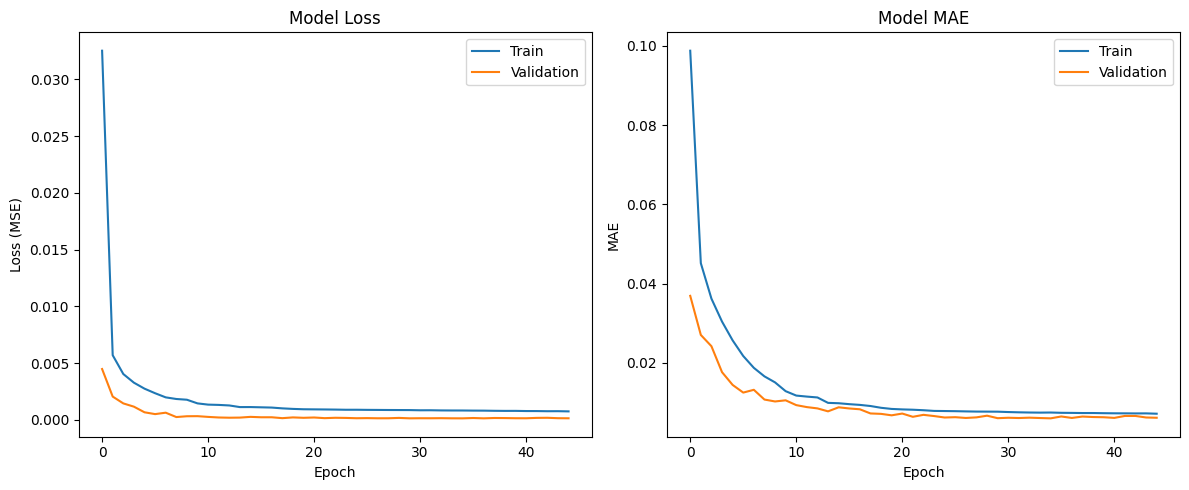

In [29]:
# Plot training history
train_plot_dir = 'training_plots/'
if not os.path.exists(train_plot_dir):
    os.makedirs(train_plot_dir)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(train_plot_dir,'training_history.png'), dpi=300)
plt.show()

In [30]:
# Save the final model
model.save(os.path.join(model_dir, 'lstm_model.keras'))

In [31]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, n_outputs)).reshape(y_test.shape)
y_pred_orig = target_scaler.inverse_transform(y_pred.reshape(-1, n_outputs)).reshape(y_pred.shape)

# Calculate error metrics on original scale
mae = mean_absolute_error(y_test_orig.reshape(-1, n_outputs), y_pred_orig.reshape(-1, n_outputs))
mape = mean_absolute_percentage_error(y_test_orig.reshape(-1, n_outputs), y_pred_orig.reshape(-1, n_outputs))
rmse = root_mean_squared_error(y_test_orig.reshape(-1, n_outputs), y_pred_orig.reshape(-1, n_outputs))

print(f"Mean Absolute Error (in original scale): {mae:.4f}")
print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
print(f"Root Mean Squared Error (in original scale): {rmse:.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Mean Absolute Error (in original scale): 0.0027
Mean Absolute Percentage Error: 3.56%
Root Mean Squared Error (in original scale): 0.0032


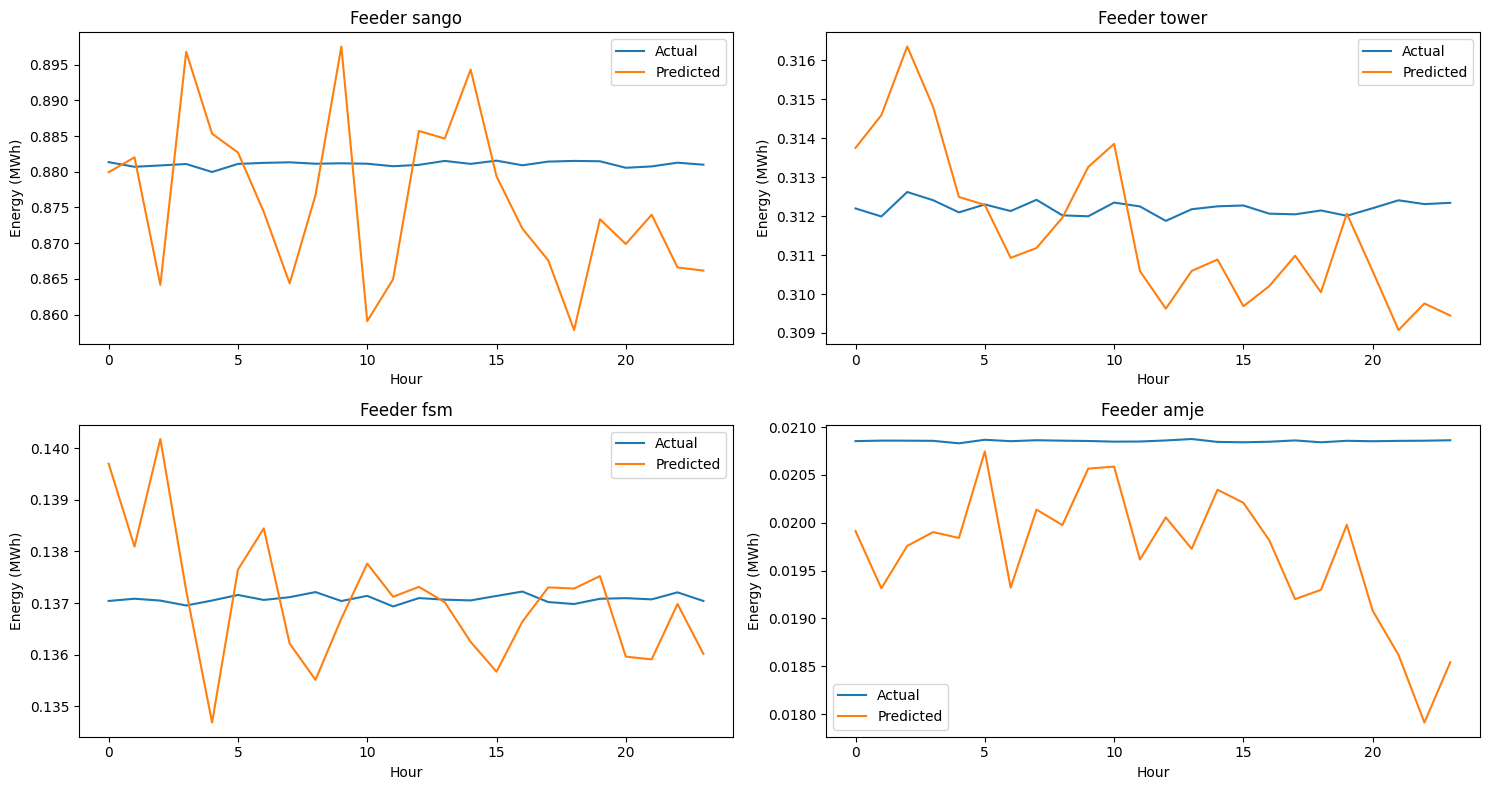

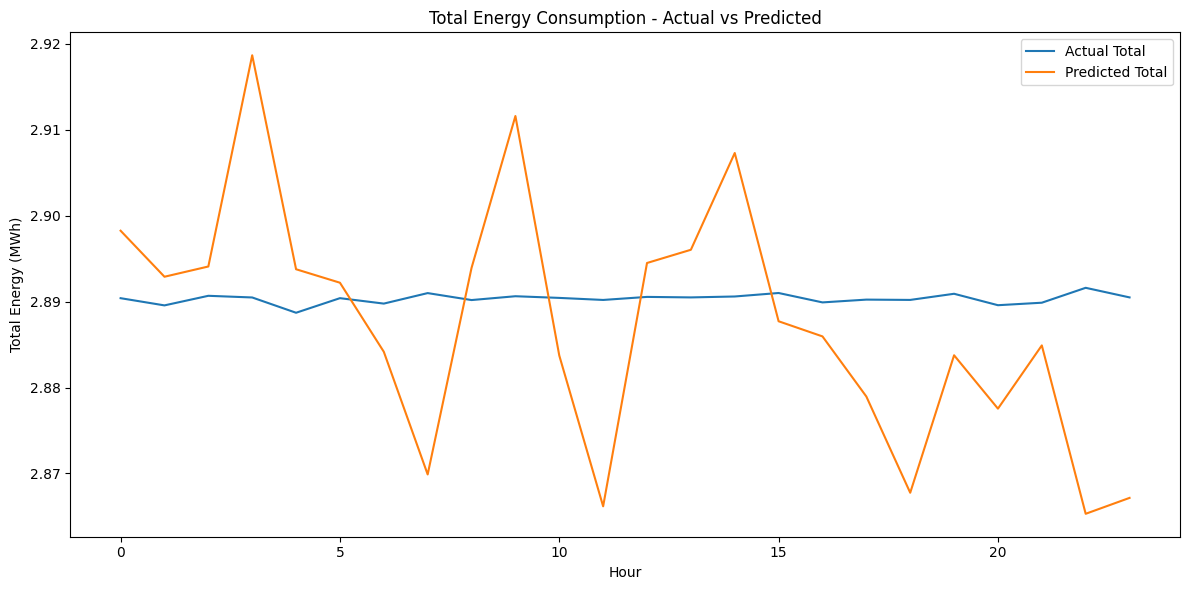

In [32]:
pred_dir = 'prediction_plots/'
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
# Plot predictions vs actual for the first test sample
sample_idx = 0

plt.figure(figsize=(15, 8))
# Plot for each feeder (first 4 for clarity)
for i in range(min(4, n_outputs)):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_orig[sample_idx, :, i], label='Actual')
    plt.plot(y_pred_orig[sample_idx, :, i], label='Predicted')
    plt.title(f'Feeder {feeder_cols[i]}')
    plt.xlabel('Hour')
    plt.ylabel('Energy (MWh)')
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(pred_dir, 'sample_predictions.png'), dpi=300)
plt.show()

# Plot total energy consumption (sum of all feeders)
plt.figure(figsize=(12, 6))
plt.plot(np.sum(y_test_orig[sample_idx], axis=1), label='Actual Total')
plt.plot(np.sum(y_pred_orig[sample_idx], axis=1), label='Predicted Total')
plt.title('Total Energy Consumption - Actual vs Predicted')
plt.xlabel('Hour')
plt.ylabel('Total Energy (MWh)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(pred_dir, 'total_prediction.png'), dpi=300)
plt.show()

## SHAP Explainable AI

In [ ]:
# Create a section for SHAP Analysis
print("=" * 80)
print("SHAP ANALYSIS: EXPLAINING MODEL PREDICTIONS")
print("=" * 80)
timestep_explain= 0

def model_predict(X):
    # Convert to the shape expected by the LSTM (adding batch and sequence dimensions if needed)
    samples= X.shape[0]
    X_reshaped = X.reshape(samples, sequence_length, n_features)
    preds = model.predict(X_reshaped, verbose=1)
    return preds[:, timestep_explain, :]

background_data = 50  # Use 50 examples as background
background_samples = X_train[:background_data]

#flatten the background samples
background_samples = background_samples.reshape(background_data, -1)
print(f"Background data shape: {background_samples.shape}")

# Initialize the SHAP explainer with the model and background data
explainer = shap.KernelExplainer(model_predict, background_samples, link="identity")

# Choose a test sample to explain
sample = X_test[sample_idx:sample_idx+1]  # Recall sample_idx= 0
#print(f"Sample shape for SHAP: {sample.shape}")
sample_flat = sample.reshape(1, -1)
print(f"Sample shape for SHAP: {sample_flat.shape}")

# Calculate SHAP values for this sample
shap_values = explainer.shap_values(sample_flat)

# Print the shape of SHAP values to understand the structure
print(f"SHAP values shape: {np.array(shap_values).shape}")

SHAP ANALYSIS: EXPLAINING MODEL PREDICTIONS
Background data shape: (50, 288)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sample shape for SHAP: (1, 24, 12)
Sample shape for SHAP: (1, 288)
Sample shape for SHAP: (1, 24, 12)
Sample shape for SHAP: (1, 288)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step


100%|██████████| 1/1 [00:59<00:00, 59.84s/it]

SHAP values shape: (1, 288, 12)


In [72]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

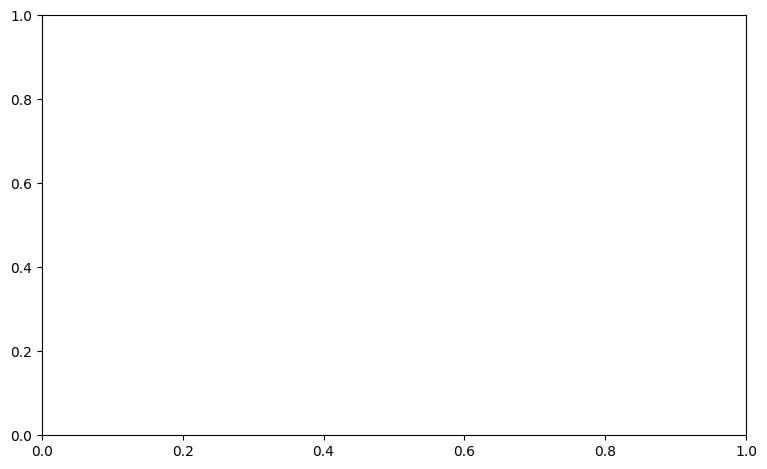

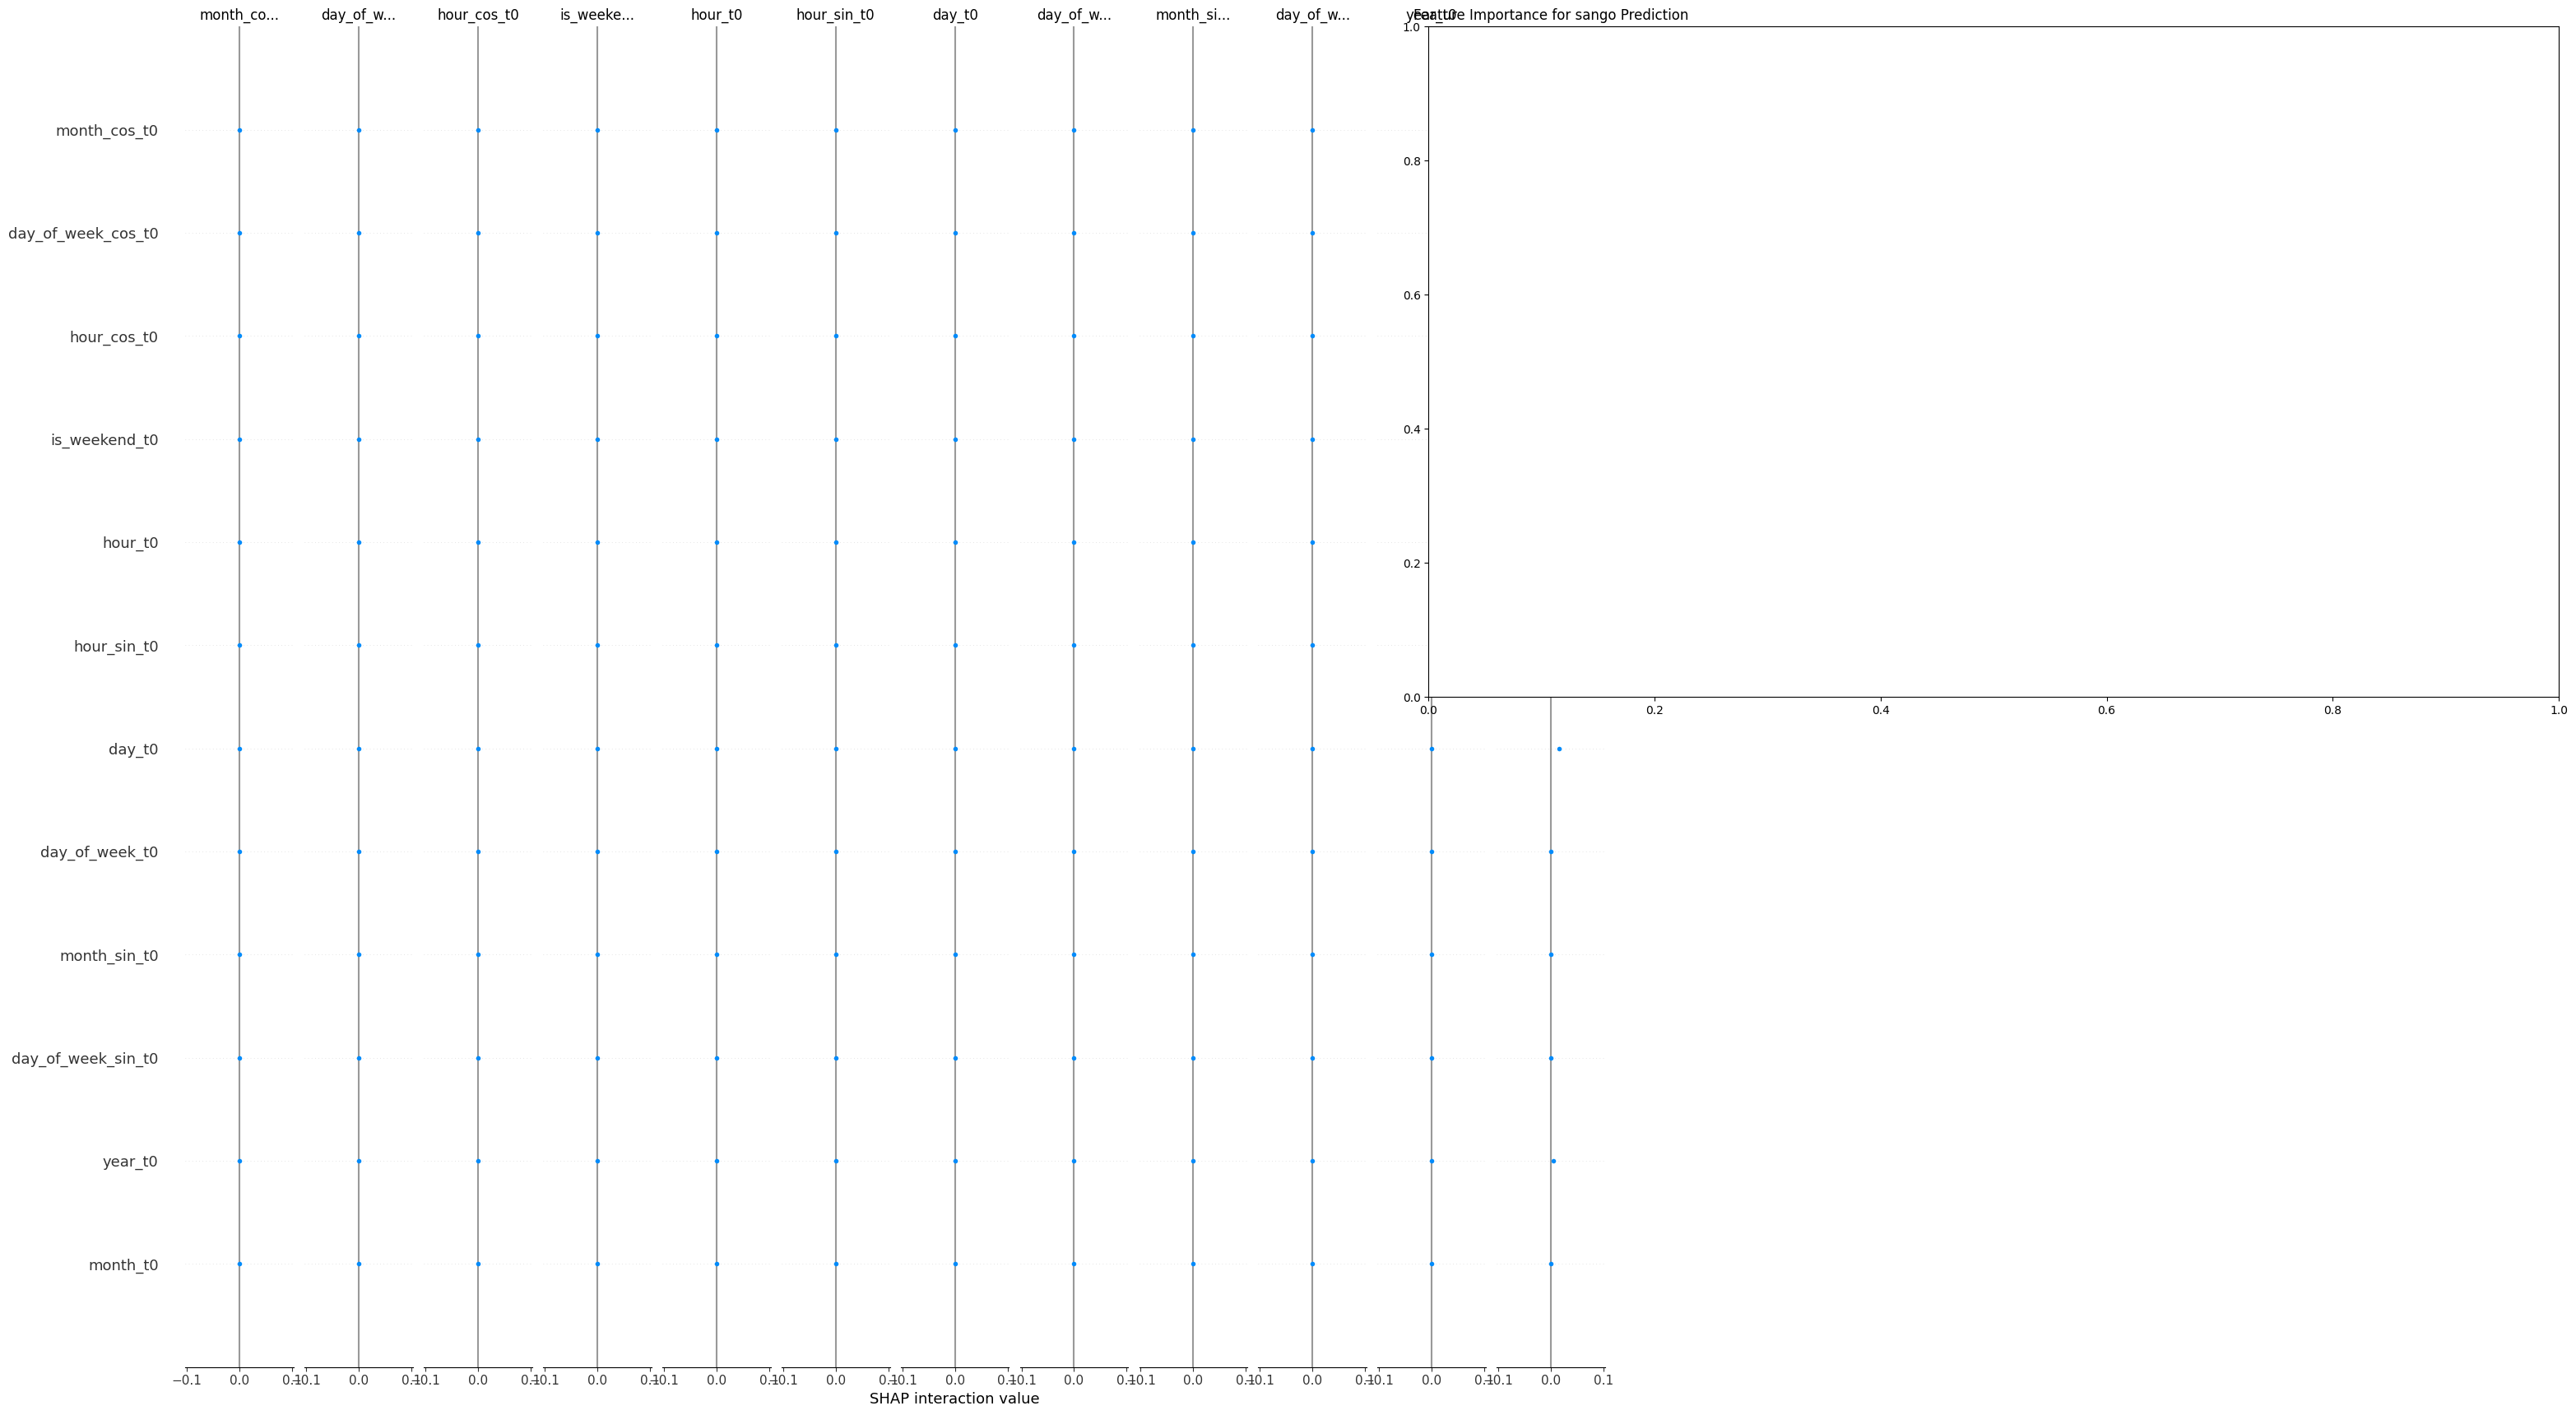

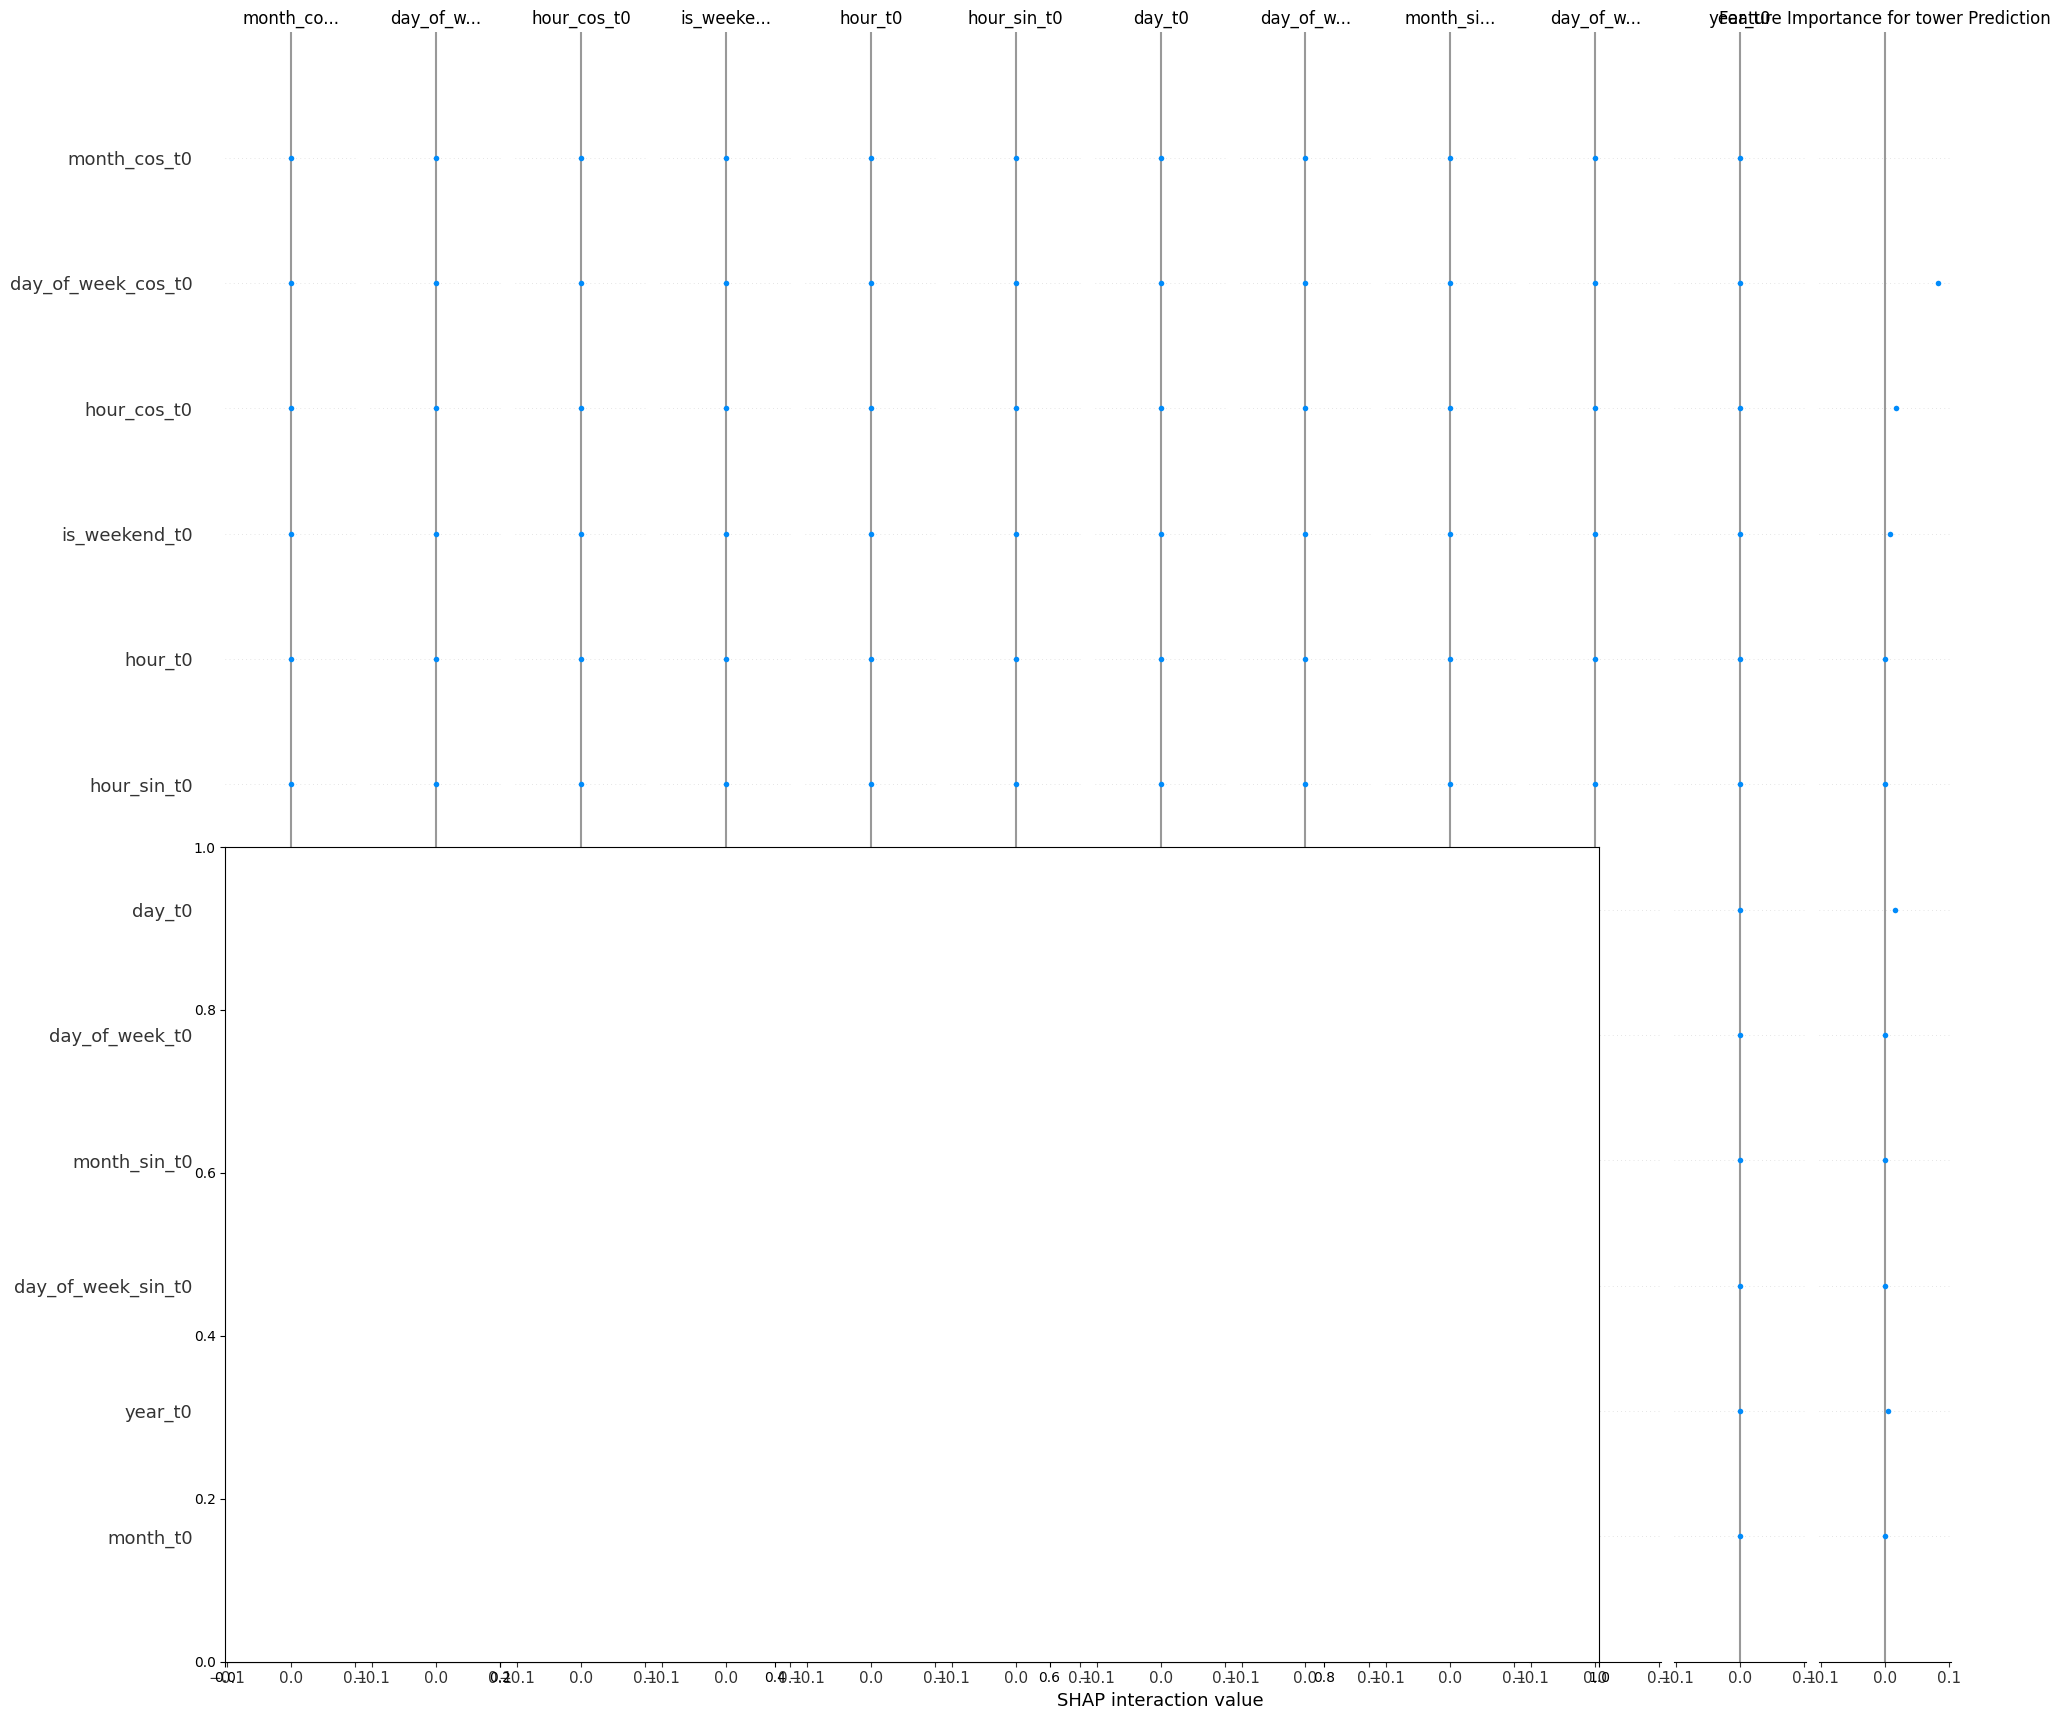

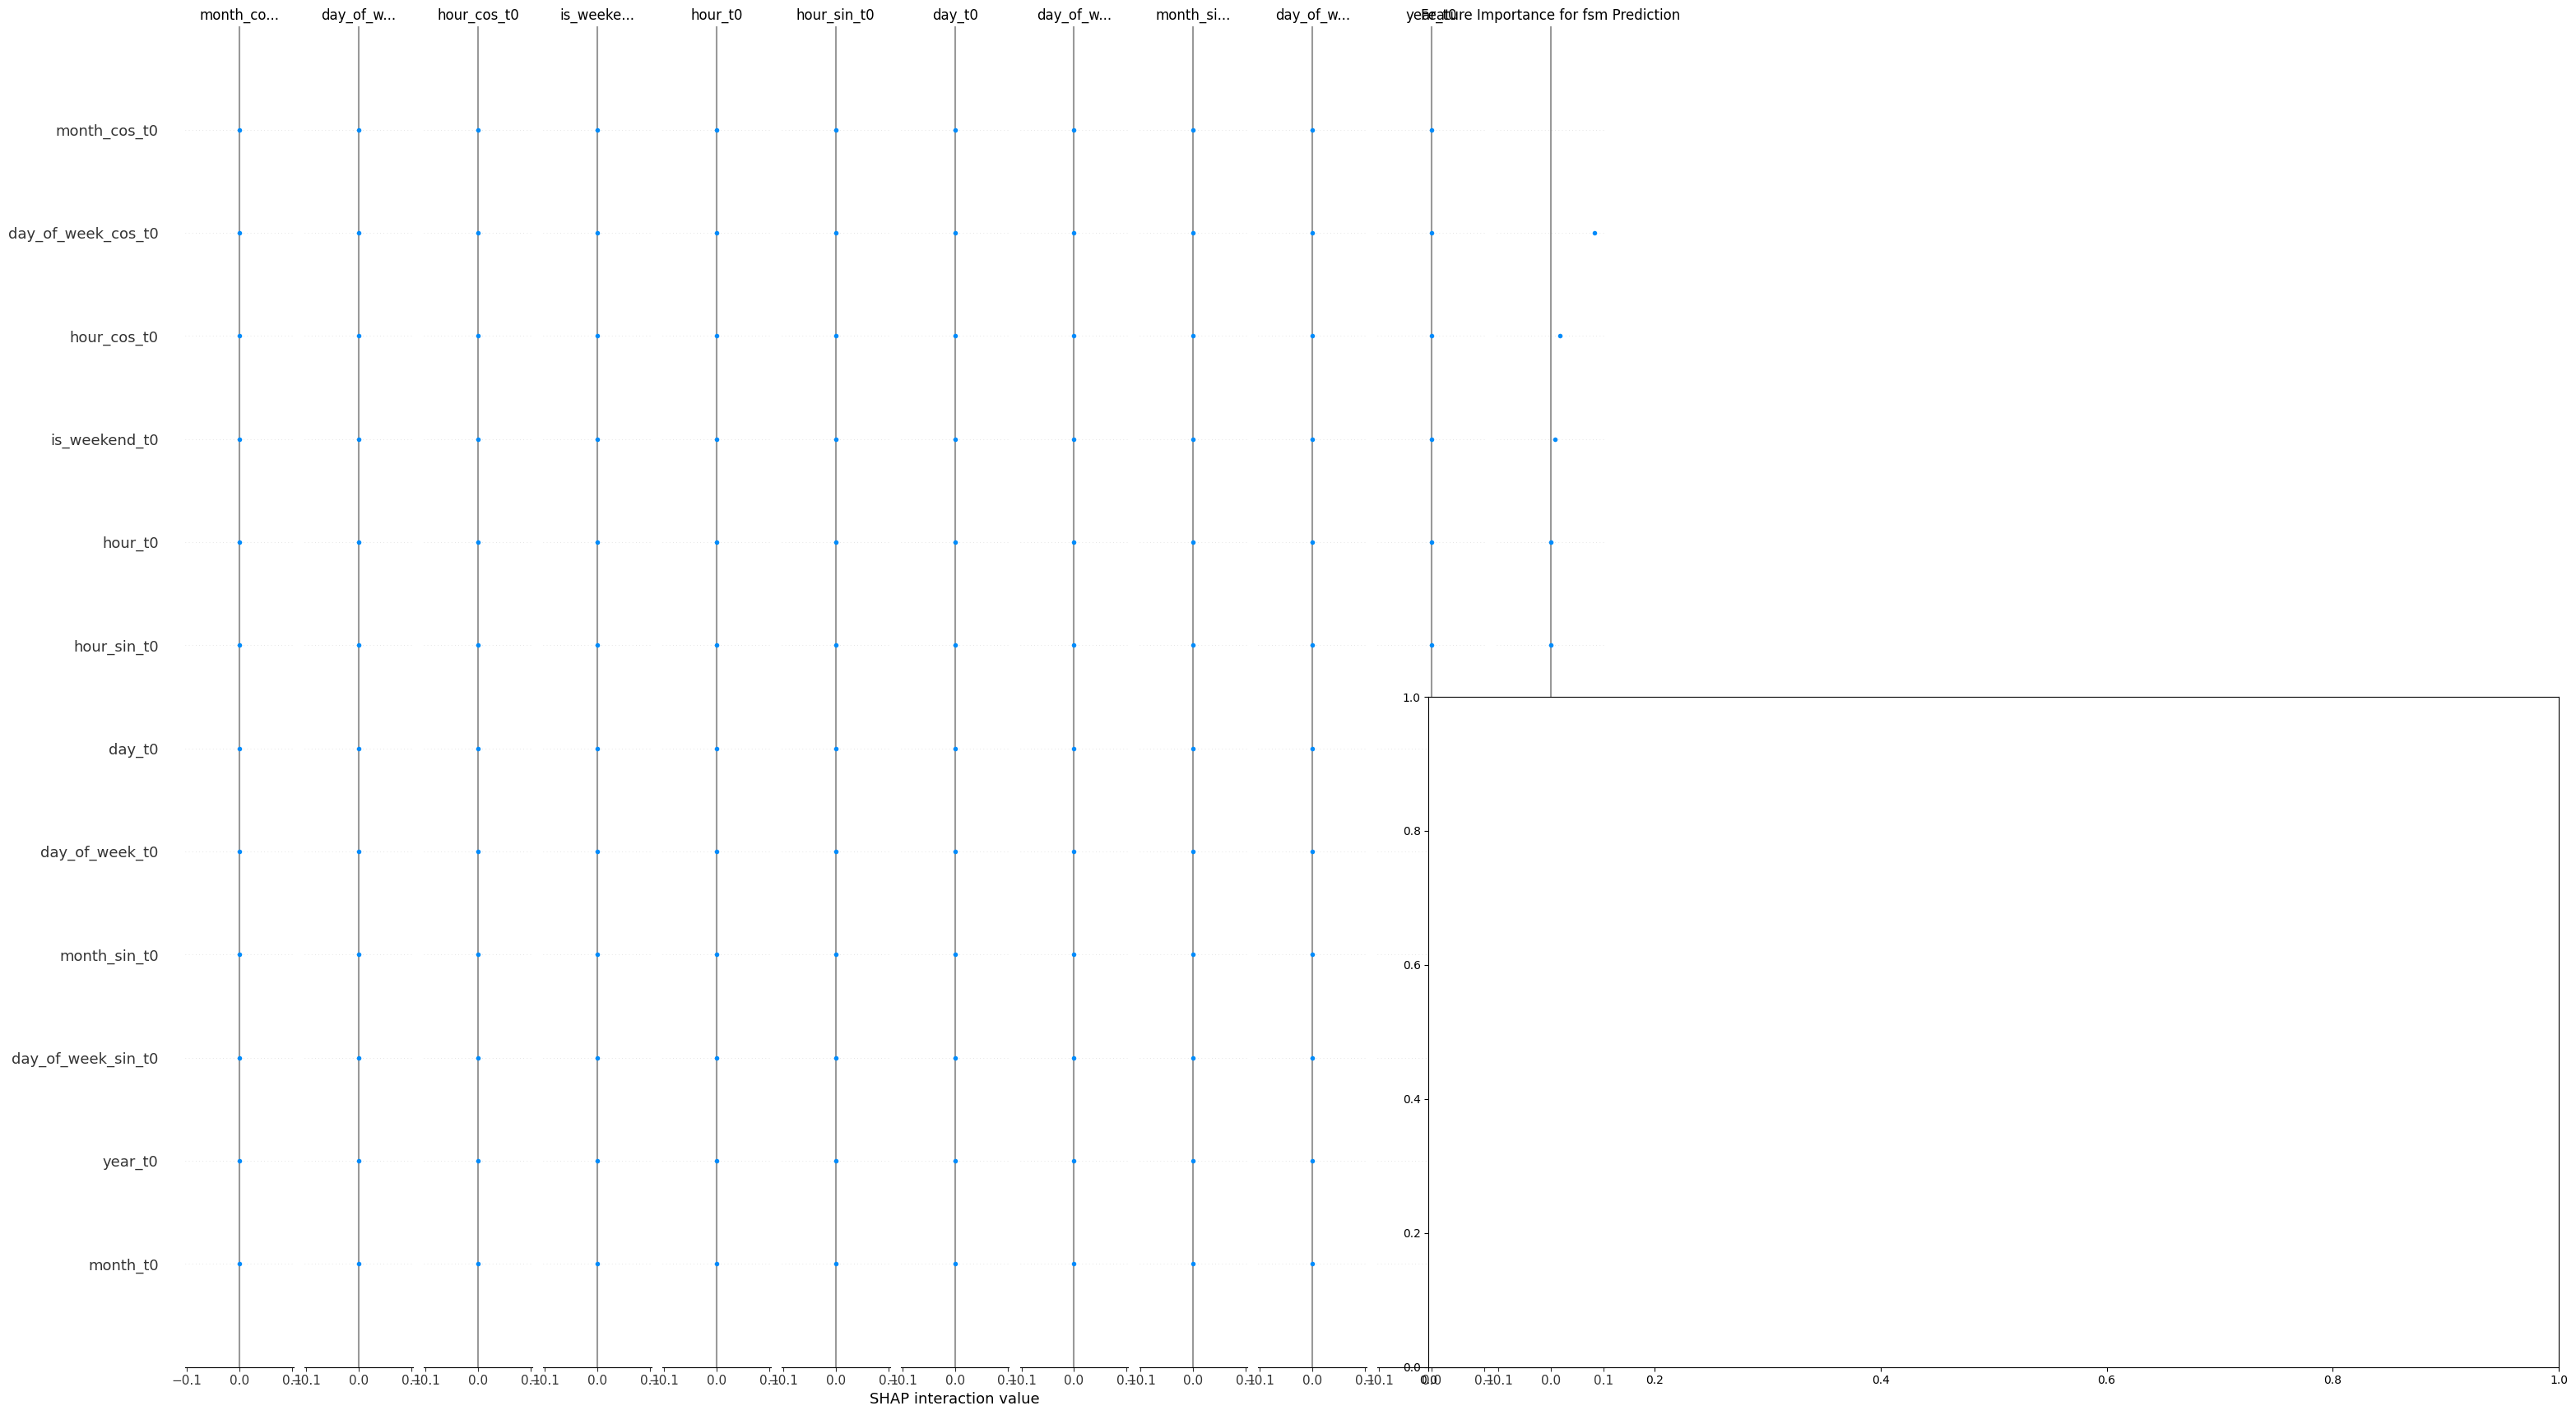

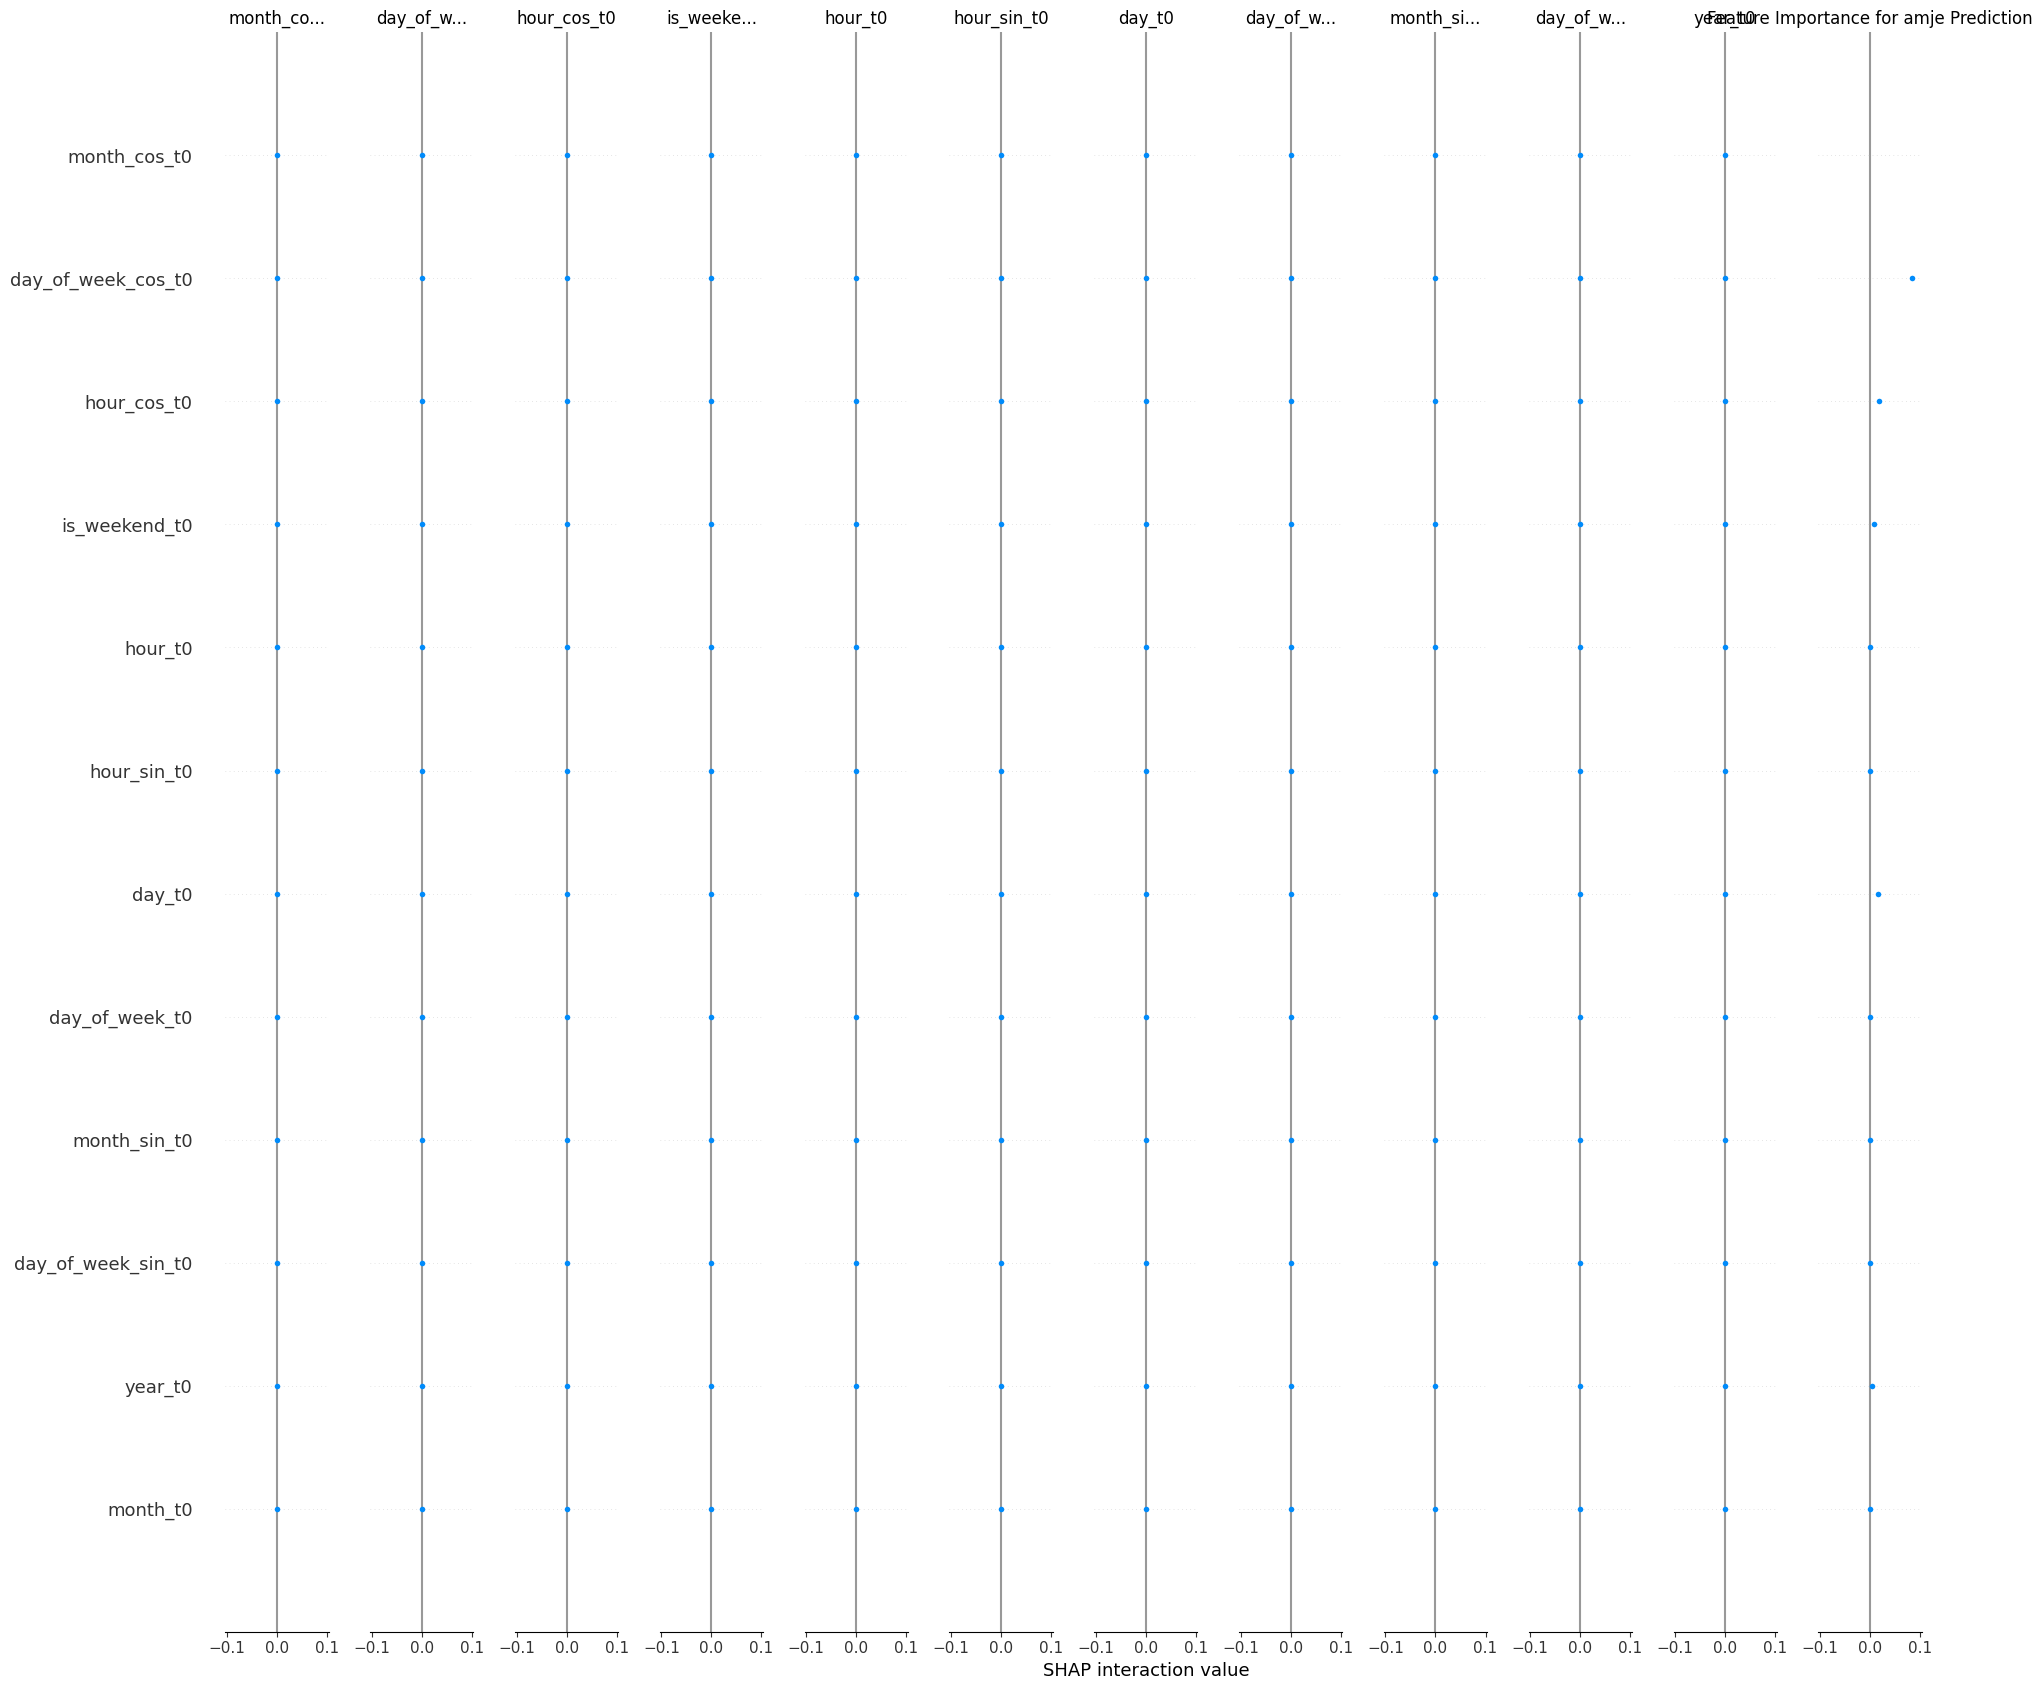

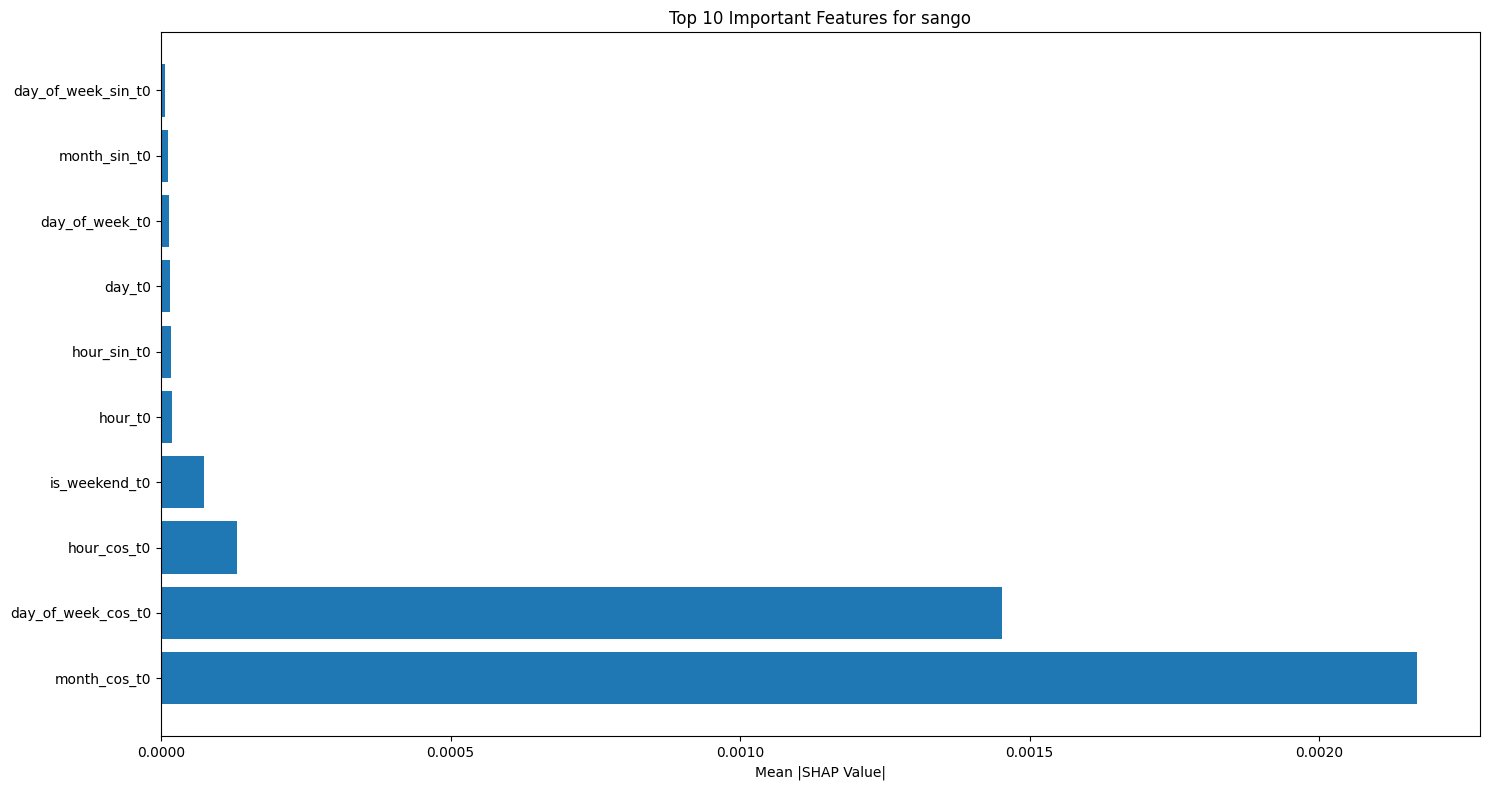

SHAP analysis completed. Results saved to the 'prediction_plots' directory.


In [73]:
# Create feature names for visualization
# We'll create feature names like 'hour_t0', 'day_of_week_t0', etc.
basic_feature_names = [
    "hour", "day_of_week", "month", "day", "year", "is_weekend",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "day_of_week_sin", "day_of_week_cos"
]

feature_names = []
for t in range(sequence_length):
    for f in basic_feature_names:
        feature_names.append(f"{f}_t{t}")

# Plot summary for each feeder
plt.figure(figsize=(20, 12))
for i in range(min(4, n_outputs)):  # Just plot first 4 feeders
    plt.subplot(2, 2, i+1)


    if shap_values.shape[0] != sample_flat.shape[0]:
        raise ValueError(
            f"Mismatch for output {i}: SHAP values have shape {shap_values.shape} "
            f"but explain_samples have shape {sample_flat.shape}"
        )

    # For summary plot, we limit to top 20 features to keep it readable
    shap.summary_plot(
        shap_values,
        sample_flat,
        feature_names=feature_names,
        max_display=20,
        show=False
    )
    plt.title(f"Feature Importance for {feeder_cols[i]} Prediction")
    
plt.tight_layout()
plt.savefig(os.path.join(pred_dir, 'shap_feature_importance.png'), dpi=300)
plt.show()

# Create a more detailed visualization for the first feeder
plt.figure(figsize=(15, 8))

# Get the most important features for the first feeder
feature_importance = np.abs(shap_values[0].mean(0))
top_indices = np.argsort(-feature_importance)[:10]  # Top 10 features
top_names = [feature_names[i] for i in top_indices]

# Create a bar chart of the most important features
plt.barh(range(len(top_names)), [feature_importance[i] for i in top_indices])
plt.yticks(range(len(top_names)), top_names)
plt.title(f"Top 10 Important Features for {feeder_cols[0]}")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.savefig(os.path.join(pred_dir, 'top_features.png'), dpi=300)
plt.show()

print("SHAP analysis completed. Results saved to the 'prediction_plots' directory.")

In [49]:
# Create a mapping of feature indices to feature names for better interpretability
feature_names = [
    "hour", "day_of_week", "month", "day", "year", "is_weekend",
    "hour_sin", "hour_cos", "month_sin", "month_cos",
    "day_of_week_sin", "day_of_week_cos"
]

# Plot force plots for the first feeder to explain individual predictions in detail
plt.figure(figsize=(15, 8))
shap.initjs()  # Initialize JavaScript visualization

# Create a force plot for the first feeder
force_plot = shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][0],
    sample_flat[0],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)

plt.title(f"Detailed SHAP Explanation for {feeder_cols[0]} Prediction")
plt.savefig(os.path.join(pred_dir, 'shap_force_plot.png'), dpi=300)
plt.show()

# Create a dependence plot to show how a specific feature affects predictions
# For example, showing how hour_sin affects predictions for the first feeder
plt.figure(figsize=(12, 6))
shap.dependence_plot(
    "hour_sin", 
    shap_values[0], 
    sample_flat,
    feature_names=feature_names,
    show=False
)
plt.title(f"How Hour (Sine Transform) Affects {feeder_cols[0]} Predictions")
plt.savefig(os.path.join(pred_dir, 'shap_dependence_plot.png'), dpi=300)
plt.show()

# Time series specific analysis
# Create a plot showing SHAP values across time for specific features
# First, we need to generate SHAP values for a sequence of predictions
sequence_to_explain = X_test[sample_idx:sample_idx+1]
sequence_shap_values = explainer.shap_values(sequence_to_explain)

# Plot SHAP values for time-related features for the first feeder
time_feature_indices = [0, 6, 7]  # hour, hour_sin, hour_cos
time_feature_names = [feature_names[i] for i in time_feature_indices]

plt.figure(figsize=(15, 8))
for i, idx in enumerate(time_feature_indices):
    plt.subplot(len(time_feature_indices), 1, i+1)
    plt.bar(range(sequence_length), sequence_shap_values[0][0, idx])
    plt.title(f"SHAP Values for {time_feature_names[i]} Over Time")
    plt.ylabel("SHAP Value")
    plt.xlabel("Time Step")

plt.tight_layout()
plt.savefig(os.path.join(pred_dir, 'shap_time_features.png'), dpi=300)
plt.show()

print("SHAP analysis completed. Results saved to the 'prediction_plots' directory.")

DimensionError: Length of features is not equal to the length of shap_values!

<Figure size 1500x800 with 0 Axes>

## Feeder Allocation

In [ ]:
# Define transformer constraints
TRANSFORMERS = {
    'T1': {'capacity': 40, 'feeders': ['sango']},
    'T2': {'capacity': 60, 'feeders': ['fsm', 'amje', 'sumo']},
    'T3': {'capacity': 100, 'feeders': ['tower']},
    'T4': {'capacity': 60, 'feeders': ['qualitec', 'arrachid', 'ijagba', 'tollgate', 'aarti']},
    'T5': {'capacity': 40, 'feeders': ['idiroko', 'estate']}
}

In [ ]:
# Priority tiers
TIER1 = {
    'SECURITY': ['sango', 'tollgate']          # Security critical
}
TIER2 = {
    'HEALTHCARE': ['idiroko']                    # Healthcare critical                        
}
TIER3 = {
    'FINANCIAL': ['qualitec', 'aarti', 'tower', 'arrachid', 'sumo']  # Financial services are Dedicated Lines
}
TIER4 = {
    'GENERAL': ['ijagba', 'amje', 'estate']        # General services; Residential, Industrial and Commercial
}

# Flattened tiers for easier processing
PRIORITY_ORDER = [
    *TIER1['SECURITY'],    # Security critical (first)
    *TIER2['HEALTHCARE'],                         # Healthcare critical (second)
    *TIER3['FINANCIAL'],                        # Financial services (third)
    *TIER4['GENERAL']                            # General purpose (last)
]
PRIORITY_TIERS = [TIER1, TIER2, TIER3, TIER4]

In [ ]:
PRIORITY_TIERS

[{'SECURITY': ['sango', 'tollgate'], 'HEALTHCARE': ['idiroko']},
 {'FINANCIAL': ['fsm']},
 {'INDUSTRIAL': ['qualitec', 'aarti', 'tower', 'arrachid', 'ijagba']},
 {'GENERAL': ['sumo', 'amje', 'estate']}]

In [ ]:
PRIORITY_ORDER

['sango',
 'tollgate',
 'idiroko',
 'fsm',
 'qualitec',
 'aarti',
 'tower',
 'arrachid',
 'ijagba',
 'sumo',
 'amje',
 'estate']

In [ ]:
def allocate_energy(forecasted_demand, available_supply):
    """
    Allocate available energy supply to feeders based on priority tiers
    
    Parameters:
    -----------
    forecasted_demand : dict
        Dictionary mapping feeder names to their forecasted demand in MW
    available_supply : float
        Total available energy supply in MW
        
    Returns:
    --------
    dict
        Dictionary mapping feeder names to allocated energy in MW
    """
    total_demand = sum(forecasted_demand.values())
    allocation = {feeder: 0 for feeder in forecasted_demand}
    
    # Case 1: Supply exceeds or equals demand
    if available_supply >= total_demand:
        print(f"Supply ({available_supply:.2f} MW) exceeds demand ({total_demand:.2f} MW)")
        print("All feeders will receive 100% of their requested demand")
        return forecasted_demand
    
    # Case 2: Demand exceeds supply - allocate by priority
    print(f"Demand ({total_demand:.2f} MW) exceeds supply ({available_supply:.2f} MW)")
    print("Allocating based on priority tiers...")
    
    remaining_supply = available_supply
    
    # Allocate by priority order
    for feeder in PRIORITY_ORDER:
        # Skip if this feeder is not in our forecast
        if feeder not in forecasted_demand:
            continue
            
        feeder_demand = forecasted_demand[feeder]
        
        # If we have enough supply for this feeder
        if remaining_supply >= feeder_demand:
            allocation[feeder] = feeder_demand
            remaining_supply -= feeder_demand
            print(f"  Allocated {feeder_demand:.2f} MW to {feeder} (100% of demand)")
        
        # If we have some supply but not enough for full demand
        elif remaining_supply > 0:
            allocation[feeder] = remaining_supply
            print(f"  Allocated {remaining_supply:.2f} MW to {feeder} ({remaining_supply/feeder_demand*100:.1f}% of demand)")
            remaining_supply = 0
        
        # If we're out of supply
        else:
            print(f" No supply left for {feeder}")
    
    return allocation

In [ ]:
def analyze_allocation(allocation, forecasted_demand):
    """Analyze and report on the energy allocation"""
    total_allocated = sum(allocation.values())
    total_demand = sum(forecasted_demand.values())
    
    print("\nAllocation Analysis:")
    print(f"Total Demand: {total_demand:.2f} MW")
    print(f"Total Allocated: {total_allocated:.2f} MW")
    print(f"Allocation Rate: {total_allocated/total_demand*100:.1f}%")
    
    # Analyze by tier
    for tier_name, tier_dict in [("TIER1 (Critical)", TIER1), 
                               ("TIER2 (Financial)", TIER2),
                               ("TIER3 (Industrial)", TIER3), 
                               ("TIER4 (General)", TIER4)]:
        tier_feeders = [f for sublist in tier_dict.values() for f in sublist]
        tier_demand = sum(forecasted_demand.get(f, 0) for f in tier_feeders)
        tier_allocated = sum(allocation.get(f, 0) for f in tier_feeders)
        
        if tier_demand > 0:
            print(f"\n{tier_name}:")
            print(f"  Demand: {tier_demand:.2f} MW")
            print(f"  Allocated: {tier_allocated:.2f} MW")
            print(f"  Satisfaction Rate: {tier_allocated/tier_demand*100:.1f}%")
            
    # Check transformer constraints
    print("\nTransformer Loading Analysis:")
    for tx_name, tx_info in TRANSFORMERS.items():
        tx_capacity = tx_info['capacity']
        tx_feeders = tx_info['feeders']
        tx_allocation = sum(allocation.get(f, 0) for f in tx_feeders)
        tx_utilization = tx_allocation / tx_capacity * 100
        
        print(f"Transformer {tx_name} ({tx_capacity} MW capacity):")
        print(f"  Feeders: {', '.join(tx_feeders)}")
        print(f"  Allocated: {tx_allocation:.2f} MW")
        print(f"  Utilization: {tx_utilization:.1f}%")

In [ ]:
def generate_one_year_forecast(model, feature_scaler, target_scaler, initial_data, n_features, n_outputs, forecast_days=30):
    """
    Generate a one-year ahead forecast using the trained LSTM model
    
    Parameters:
    -----------
    model : keras.Model
        Trained LSTM model
    feature_scaler : MinMaxScaler
        Scaler used for features
    target_scaler : MinMaxScaler
        Scaler used for targets
    initial_data : np.array
        Initial input data for the model (must be of shape [1, sequence_length, n_features])
    n_features : int
        Number of input features
    n_outputs : int
        Number of outputs (number of feeders)
    forecast_days : int
        Number of days to forecast (default: 365)
        
    Returns:
    --------
    np.array
        Forecasted values for each feeder for each day in original scale
    """
    # Initialize containers for forecast
    forecast_hours = forecast_days * 24  # 24 hours per day
    predictions = np.zeros((forecast_hours, n_outputs))
    
    # Make a copy of the initial input data
    current_input = initial_data.copy()
    
    # Generate forecasts one day at a time
    for hour in range(forecast_hours):
        # Generate forecast for next hour
        next_hour_forecast = model.predict(current_input)
        
        # Store the forecast for this hour
        predictions[hour] = next_hour_forecast[0, 0, :]
        
        # Update the input for the next prediction
        # Shift the window forward by one step and append the new prediction
        current_input[0, :-1, :] = current_input[0, 1:, :]
        
        # Create new features for the next time step (this would need customization based on your features)
        # This is a simplified version that assumes your features include hour of day, day of week, etc.
        # For a real implementation, you'd need to update all time-based features correctly
        # For now, we'll just use the last row's features
        current_input[0, -1, :] = current_input[0, -1, :]
    
    # Convert predictions back to original scale
    predictions_orig = target_scaler.inverse_transform(predictions)
    
    return predictions_orig



In [ ]:
# Function to simulate the allocation system with different supply scenarios
def run_allocation_simulation(forecasted_demand, base_demand_total, variation_percentages=[-20, -10, 0, 10, 20]):
    """
    Run energy allocation simulations for different supply scenarios
    
    Parameters:
    -----------
    forecasted_demand : dict
        Dictionary mapping feeder names to their forecasted demand in MW
    base_demand_total : float
        Total base demand for normalization
    variation_percentages : list
        List of percentage variations from the base demand to simulate
    """
    print("=" * 80)
    print("ENERGY ALLOCATION SIMULATION")
    print("=" * 80)
    
    # Test with different supply levels
    for variation in variation_percentages:
        available_supply = base_demand_total * (1 + variation/100)
        print("\n" + "=" * 60)
        print(f"SCENARIO: Supply at {100+variation}% of demand ({available_supply:.2f} MW)")
        print("=" * 60)
        
        # Run the allocation algorithm
        allocation = allocate_energy(forecasted_demand, available_supply)
        
        # Analyze the results
        analyze_allocation(allocation, forecasted_demand)

In [ ]:
def visualize_allocation(allocation, forecasted_demand):
    """
    Visualize the energy allocation results
    
    Parameters:
    -----------
    allocation : dict
        Dictionary mapping feeder names to allocated energy in MW
    forecasted_demand : dict
        Dictionary mapping feeder names to forecasted demand in MW
    """
    # Create allocation plot directory
    alloc_dir = 'allocation_plots/'
    if not os.path.exists(alloc_dir):
        os.makedirs(alloc_dir)
    
    # Prepare data for visualization
    feeders = list(allocation.keys())
    allocated = [allocation[f] for f in feeders]
    demanded = [forecasted_demand[f] for f in feeders]
    
    # Calculate allocation percentage
    allocation_pct = [allocation[f]/forecasted_demand[f]*100 if forecasted_demand[f] > 0 else 0 for f in feeders]
    
    # Sort by priority tier
    tier_order = {f: i for i, f in enumerate(PRIORITY_ORDER)}
    feeders_sorted = sorted(feeders, key=lambda x: tier_order.get(x, 999))
    allocated_sorted = [allocation[f] for f in feeders_sorted]
    demanded_sorted = [forecasted_demand[f] for f in feeders_sorted]
    allocation_pct_sorted = [allocation[f]/forecasted_demand[f]*100 if forecasted_demand[f] > 0 else 0 for f in feeders_sorted]
    
    # Create a color map for the tiers
    tier_colors = {
        'SECURITY': 'darkred',
        'HEALTHCARE': 'red',
        'FINANCIAL': 'orange',
        'INDUSTRIAL': 'teal',
        'GENERAL': 'gray'
    }
    
    colors = []
    for f in feeders_sorted:
        if f in TIER1['SECURITY']:
            colors.append(tier_colors['SECURITY'])
        elif f in TIER1['HEALTHCARE']:
            colors.append(tier_colors['HEALTHCARE'])
        elif f in TIER2['FINANCIAL']:
            colors.append(tier_colors['FINANCIAL'])
        elif f in TIER3['INDUSTRIAL']:
            colors.append(tier_colors['INDUSTRIAL'])
        else:
            colors.append(tier_colors['GENERAL'])
    
    # 1. Allocation vs Demand Bar Chart
    plt.figure(figsize=(15, 8))
    x = range(len(feeders_sorted))
    width = 0.35
    
    plt.bar(x, demanded_sorted, width, label='Demand', color='lightgray', edgecolor='black')
    plt.bar(x, allocated_sorted, width, label='Allocated', color=colors, alpha=0.7)
    
    plt.xlabel('Feeder')
    plt.ylabel('Energy (MW)')
    plt.title('Energy Allocation vs Demand by Feeder')
    plt.xticks(x, feeders_sorted, rotation=45)
    plt.legend()
    
    # Add tier-based labels
    plt.axvline(x=len(TIER1['SECURITY'])+len(TIER1['HEALTHCARE'])-0.5, color='black', linestyle='--')
    plt.axvline(x=len(TIER1['SECURITY'])+len(TIER1['HEALTHCARE'])+len(TIER2['FINANCIAL'])-0.5, color='black', linestyle='--')
    plt.axvline(x=len(TIER1['SECURITY'])+len(TIER1['HEALTHCARE'])+len(TIER2['FINANCIAL'])+len(TIER3['INDUSTRIAL'])-0.5, color='black', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(os.path.join(alloc_dir, 'allocation_vs_demand.png'), dpi=300)
    plt.show()
    
    # 2. Allocation Percentage Bar Chart
    plt.figure(figsize=(15, 8))
    plt.bar(x, allocation_pct_sorted, color=colors, alpha=0.7)
    plt.axhline(y=100, color='red', linestyle='--')
    
    plt.xlabel('Feeder')
    plt.ylabel('Allocation Percentage (%)')
    plt.title('Energy Allocation Percentage by Feeder')
    plt.xticks(x, feeders_sorted, rotation=45)
    
    # Add tier-based labels
    plt.axvline(x=len(TIER1['SECURITY'])+len(TIER1['HEALTHCARE'])-0.5, color='black', linestyle='--')
    plt.axvline(x=len(TIER1['SECURITY'])+len(TIER1['HEALTHCARE'])+len(TIER2['FINANCIAL'])-0.5, color='black', linestyle='--')
    plt.axvline(x=len(TIER1['SECURITY'])+len(TIER1['HEALTHCARE'])+len(TIER2['FINANCIAL'])+len(TIER3['INDUSTRIAL'])-0.5, color='black', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(os.path.join(alloc_dir, 'allocation_percentage.png'), dpi=300)
    plt.show()
    
    # 3. Tier-based allocation pie chart
    plt.figure(figsize=(12, 8))
    tier_names = ['Security', 'Healthcare', 'Financial', 'Industrial', 'General']
    tier_demands = [
        sum(forecasted_demand.get(f, 0) for f in TIER1['SECURITY']),
        sum(forecasted_demand.get(f, 0) for f in TIER1['HEALTHCARE']),
        sum(forecasted_demand.get(f, 0) for f in TIER2['FINANCIAL']),
        sum(forecasted_demand.get(f, 0) for f in TIER3['INDUSTRIAL']),
        sum(forecasted_demand.get(f, 0) for f in TIER4['GENERAL'])
    ]
    tier_allocated = [
        sum(allocation.get(f, 0) for f in TIER1['SECURITY']),
        sum(allocation.get(f, 0) for f in TIER1['HEALTHCARE']),
        sum(allocation.get(f, 0) for f in TIER2['FINANCIAL']),
        sum(allocation.get(f, 0) for f in TIER3['INDUSTRIAL']),
        sum(allocation.get(f, 0) for f in TIER4['GENERAL'])
    ]
    tier_colors_list = [tier_colors['SECURITY'], tier_colors['HEALTHCARE'], tier_colors['FINANCIAL'], tier_colors['INDUSTRIAL'], tier_colors['GENERAL']]
    
    plt.subplot(1, 2, 1)
    plt.pie(tier_demands, labels=tier_names, autopct='%1.1f%%', colors=tier_colors_list)
    plt.title('Demand Distribution by Priority Tier')
    
    plt.subplot(1, 2, 2)
    plt.pie(tier_allocated, labels=tier_names, autopct='%1.1f%%', colors=tier_colors_list)
    plt.title('Allocation Distribution by Priority Tier')
    
    plt.tight_layout()
    plt.savefig(os.path.join(alloc_dir, 'tier_allocation.png'), dpi=300)
    plt.show()

In [ ]:
model

<Sequential name=sequential, built=True>

In [ ]:
def run_intelligent_energy_management(model, feature_scaler, target_scaler, last_known_data, feeder_cols, supply_variations=[-20, -10, 0, 10, 20]):
    """
    Run the intelligent energy management system
    
    Parameters:
    -----------
    model : keras.Model
        Trained LSTM model
    feature_scaler : MinMaxScaler
        Scaler used for features
    target_scaler : MinMaxScaler
        Scaler used for targets
    last_known_data : np.array
        Last known data point to start the forecast
    feeder_cols : list
        List of feeder column names
    supply_variations : list
        List of percentage variations from the base demand to simulate
    """
    # Generate forecast for next 24 hours
    # For a full year forecast, you would use generate_one_year_forecast() instead
    next_day_forecast = model.predict(last_known_data)
    
    # Convert forecast to original scale
    n_outputs = len(feeder_cols)
    forecast_orig = target_scaler.inverse_transform(
        next_day_forecast.reshape(-1, n_outputs)
    ).reshape(next_day_forecast.shape)
    
    # Calculate total energy demand for each feeder for the next day
    daily_demand = {}
    for i, feeder in enumerate(feeder_cols):
        # Sum across 24 hours to get total daily demand
        daily_demand[feeder] = np.sum(forecast_orig[0, :, i])
    
    # Run the allocation simulation with different supply scenarios
    total_demand = sum(daily_demand.values())
    sharing_ratios = {feeder: (demand/total_demand*100) for feeder, demand in daily_demand.items()}

# Print the sharing ratios in descending order
    for feeder, ratio in sorted(sharing_ratios.items(), key=lambda x: x[1], reverse=True):
        print(f"The sharing ratio for {feeder}: {ratio:.2f}%")
    run_allocation_simulation(daily_demand, total_demand, supply_variations)
    
    # Store allocations for each scenario
    allocations = {}
    for variation in supply_variations:
        available_supply = total_demand * (1 + variation/100)
        scenario_name = f"{100+variation}% of demand ({available_supply:.2f} MW)"
        allocations[scenario_name] = allocate_energy(daily_demand, available_supply)
    
    # Visualize each scenario (or select specific ones to visualize)
    for scenario_name, allocation in allocations.items():
        print(f"\nVisualizing scenario: {scenario_name}")
        visualize_allocation(allocation, daily_demand)
    
    # Return the demand and all allocations
    return daily_demand, allocations

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The sharing ratio for sango: 30.19%
The sharing ratio for estate: 23.47%
The sharing ratio for tollgate: 11.03%
The sharing ratio for tower: 10.87%
The sharing ratio for idiroko: 8.77%
The sharing ratio for ijagba: 6.58%
The sharing ratio for fsm: 4.77%
The sharing ratio for sumo: 2.45%
The sharing ratio for amje: 0.68%
The sharing ratio for arrachid: 0.48%
The sharing ratio for aarti: 0.38%
The sharing ratio for qualitec: 0.31%
ENERGY ALLOCATION SIMULATION

SCENARIO: Supply at 80% of demand (55.08 MW)
Demand (68.85 MW) exceeds supply (55.08 MW)
Allocating based on priority tiers...
  Allocated 20.79 MW to sango (100% of demand)
  Allocated 7.59 MW to tollgate (100% of demand)
  Allocated 6.04 MW to idiroko (100% of demand)
  Allocated 3.29 MW to fsm (100% of demand)
  Allocated 0.22 MW to qualitec (100% of demand)
  Allocated 0.26 MW to aarti (100% of demand)
  Allocated 7.49 MW to tower (100% of demand)
  Allocated 0.33 MW to arrachid (100% of de

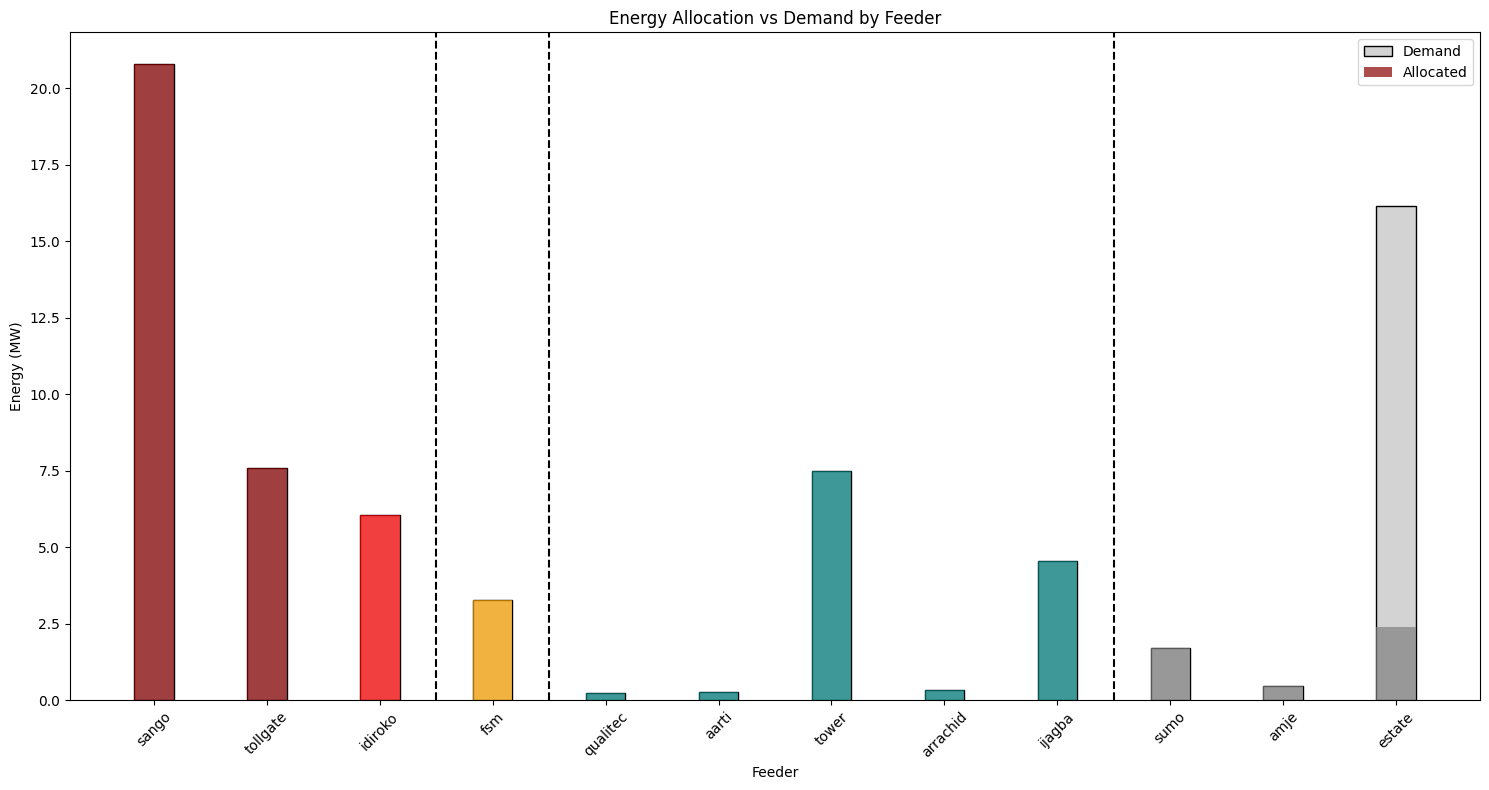

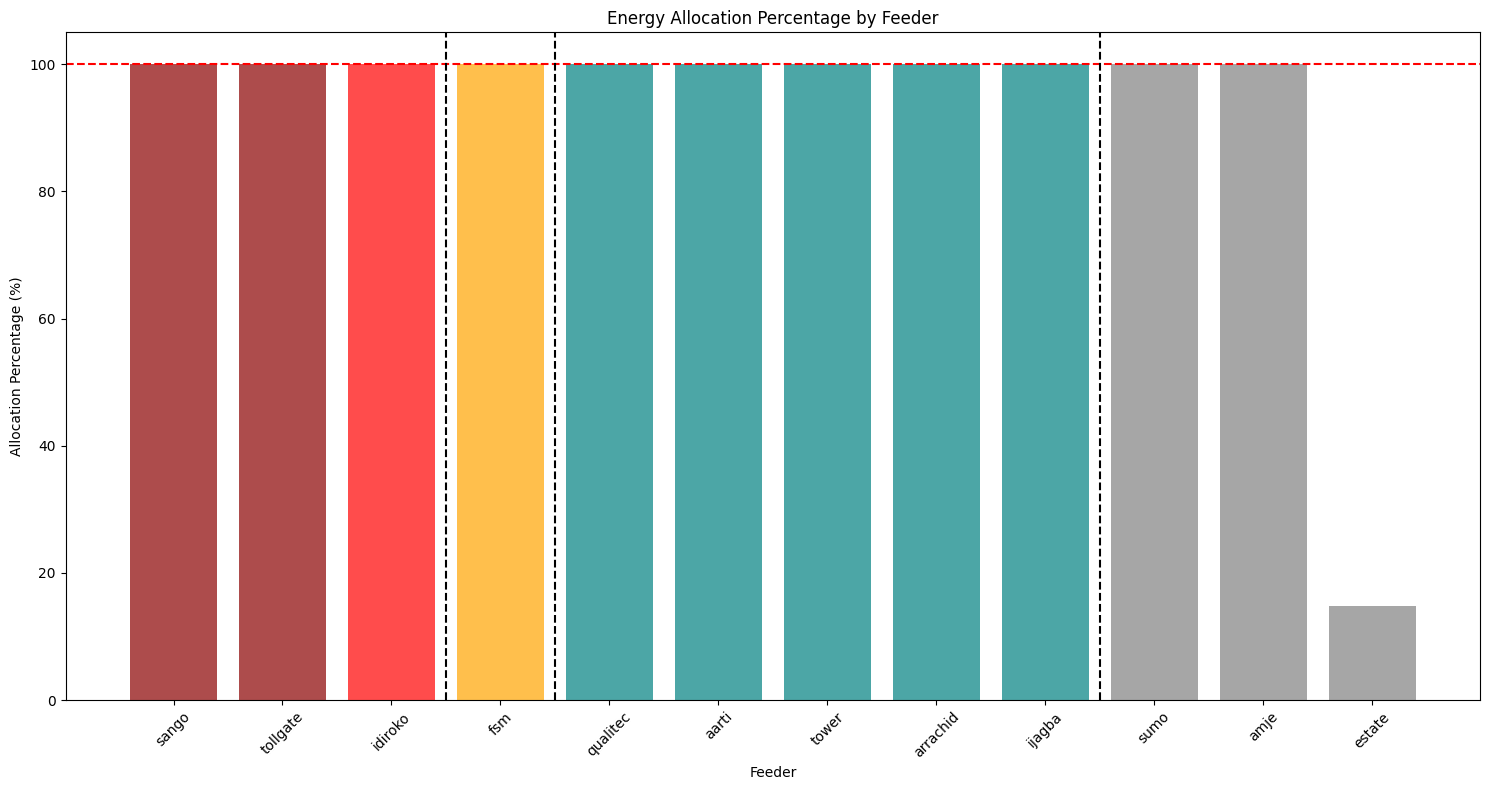

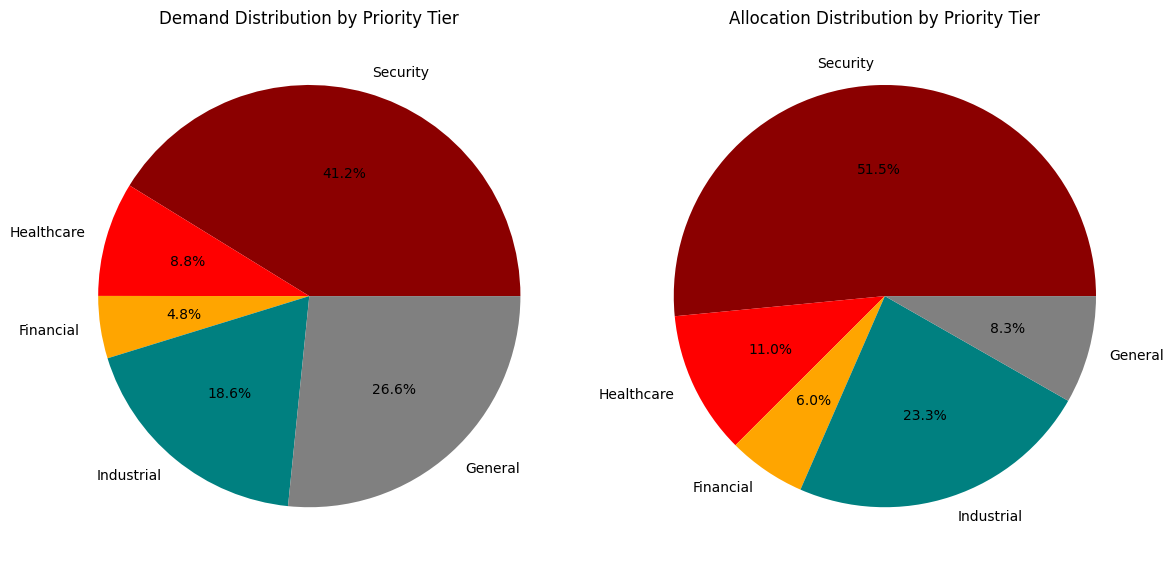


Visualizing scenario: 90% of demand (61.96 MW)


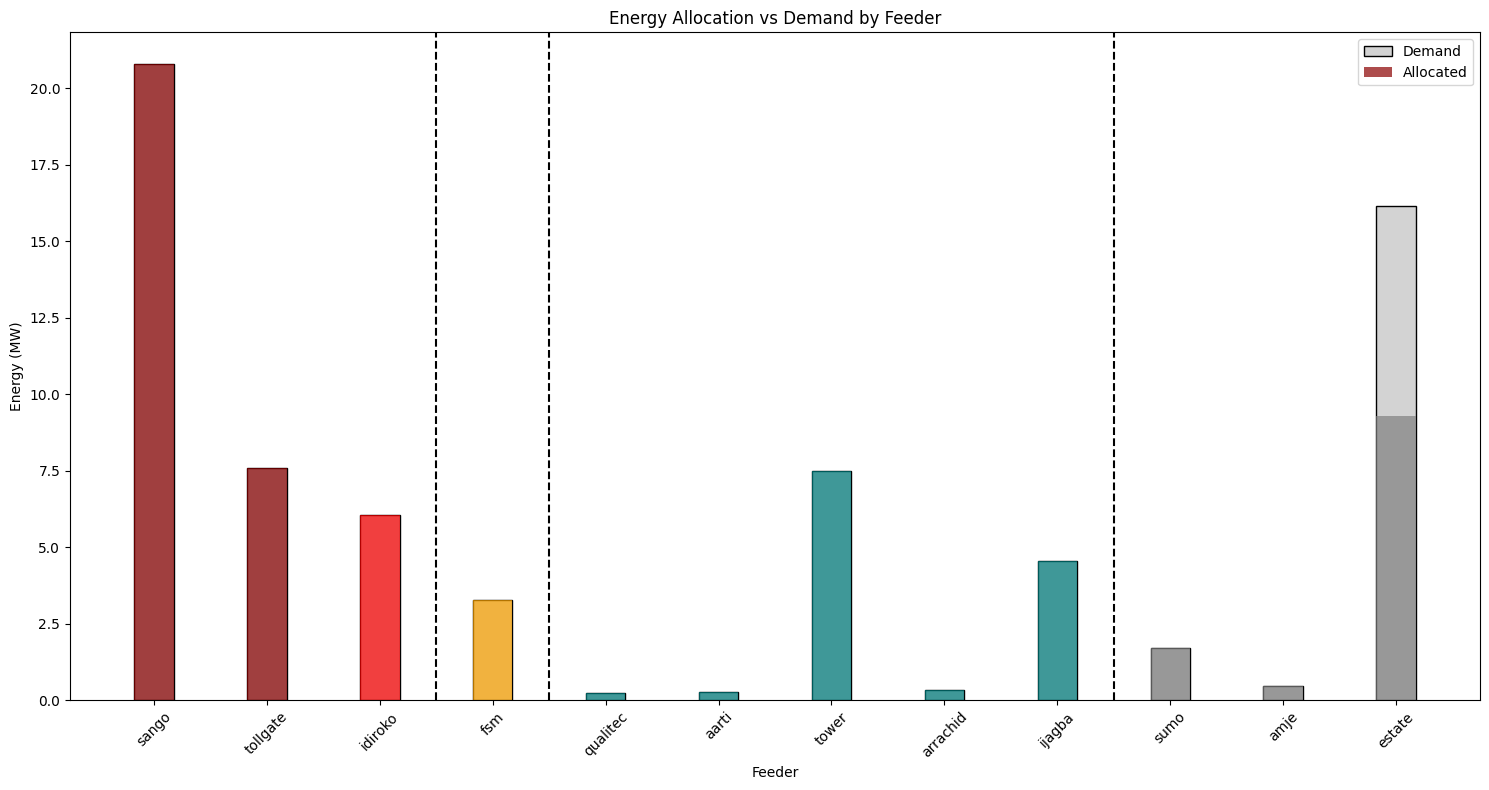

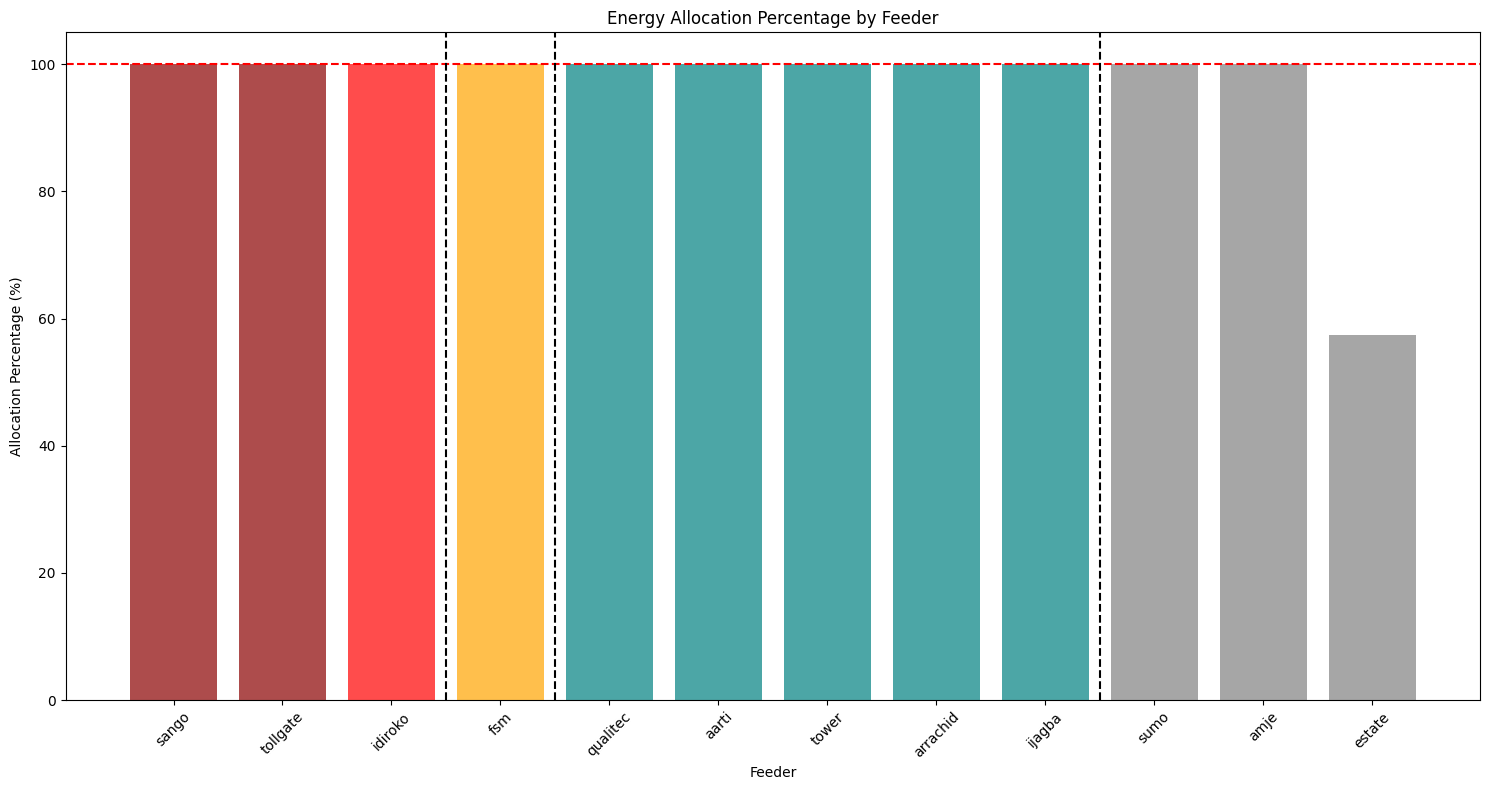

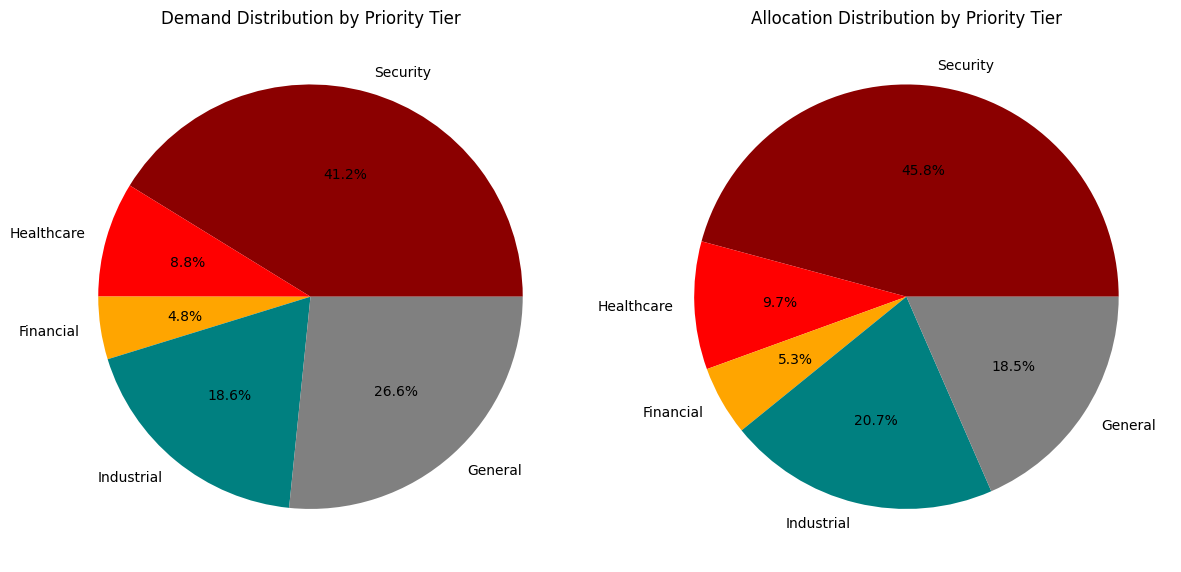


Visualizing scenario: 100% of demand (68.85 MW)


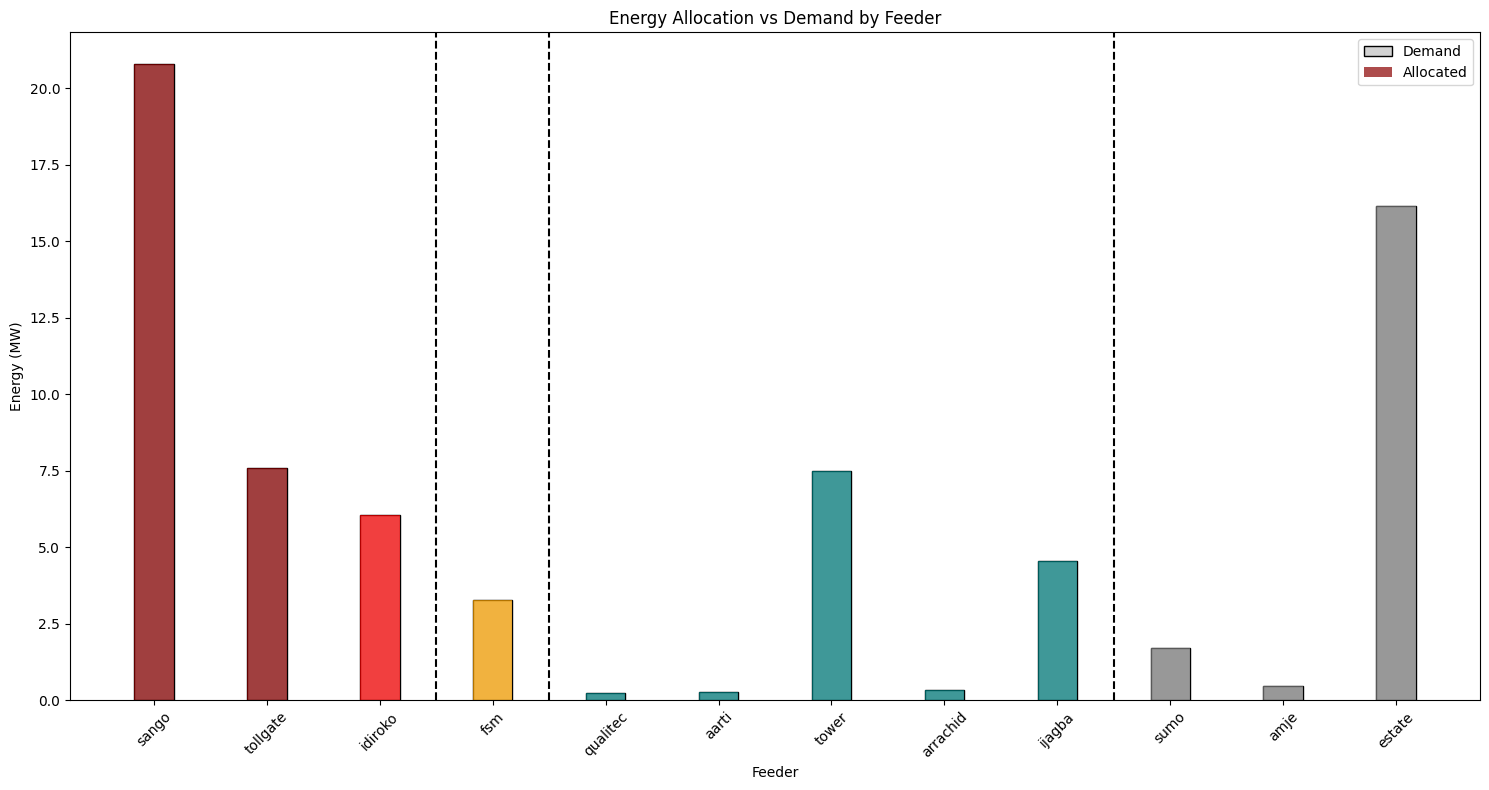

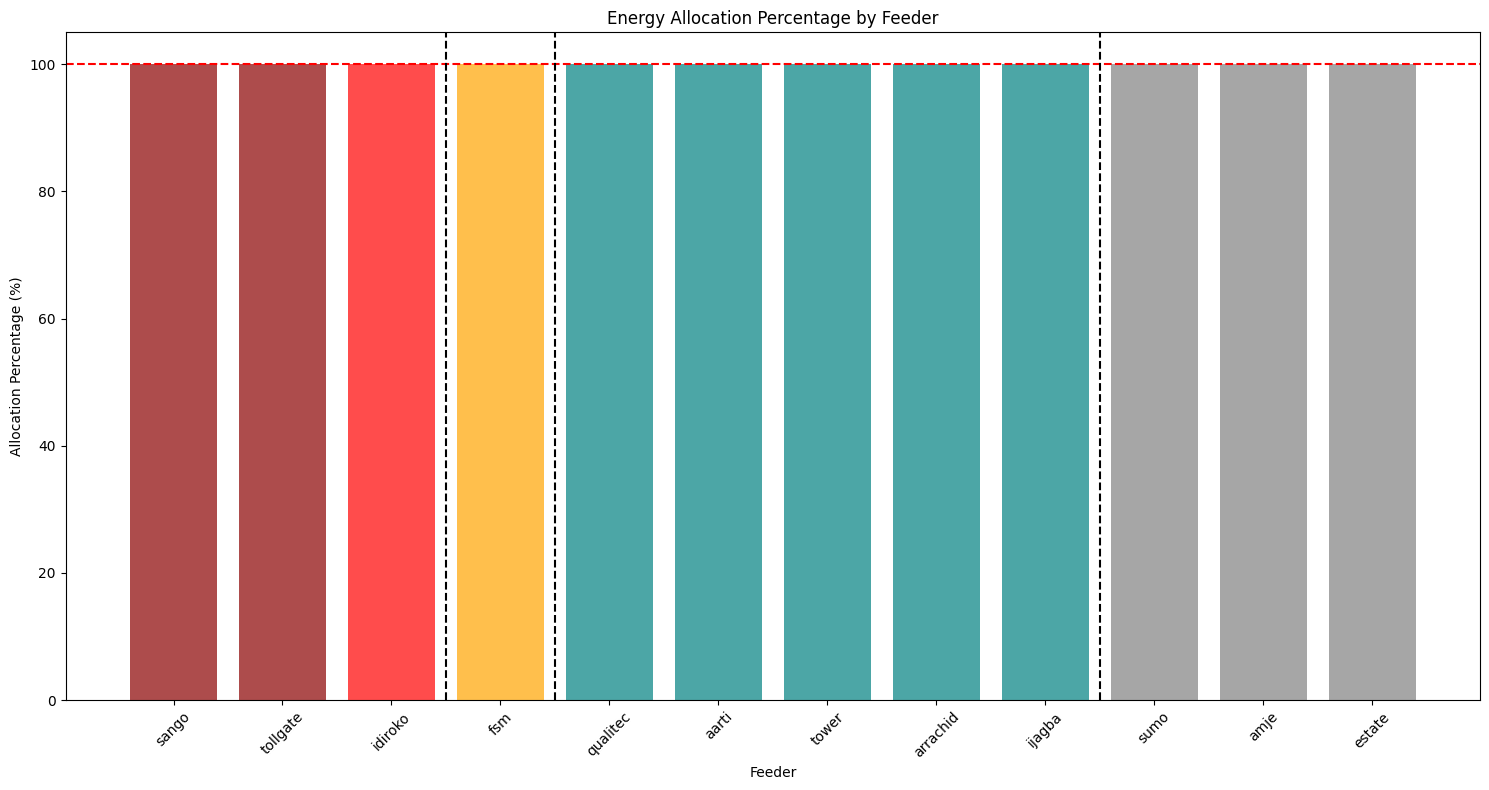

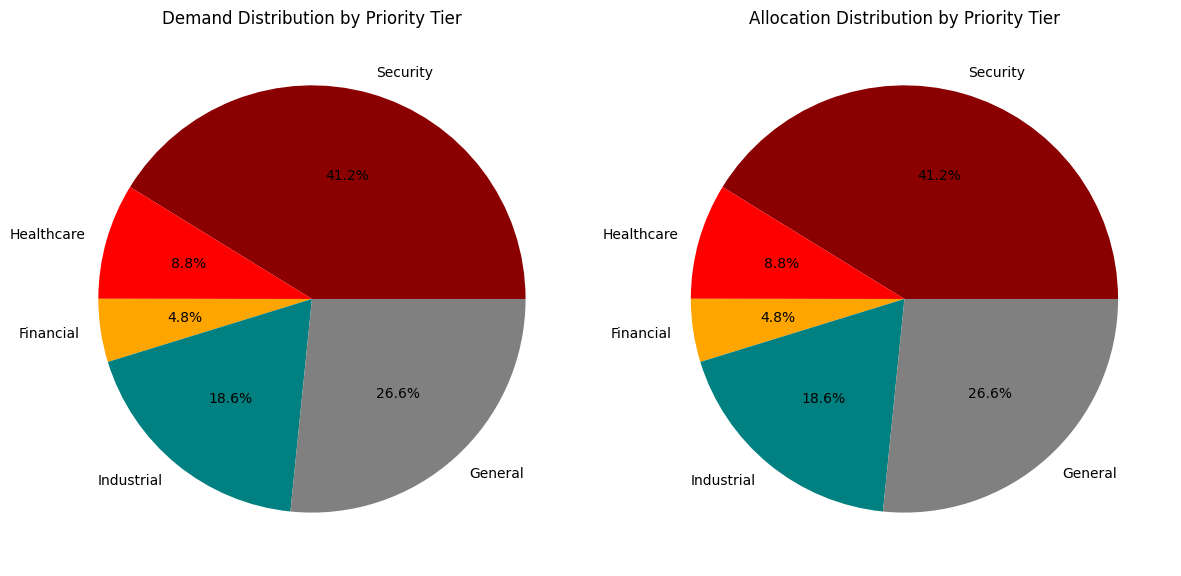


Visualizing scenario: 110% of demand (75.73 MW)


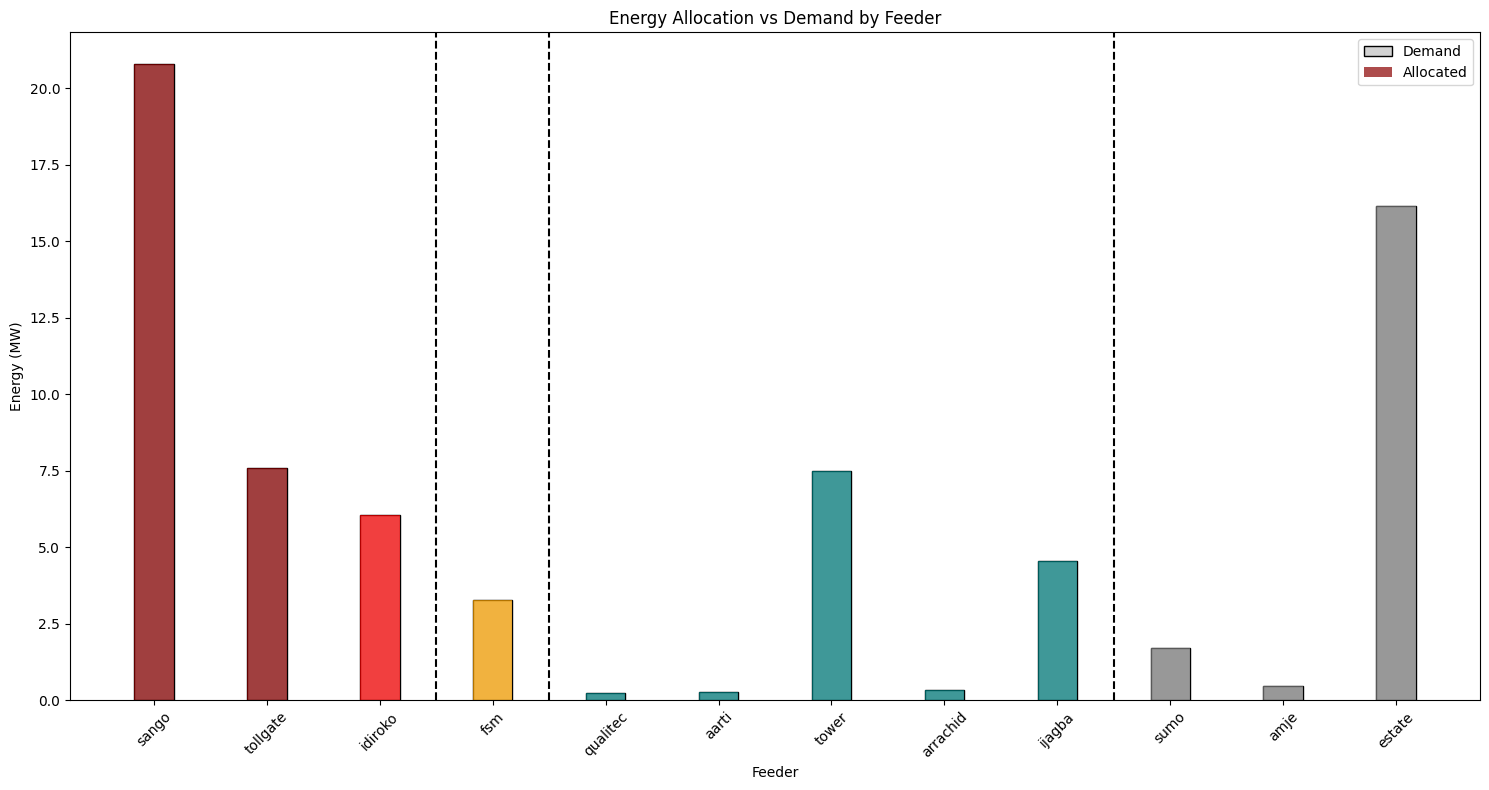

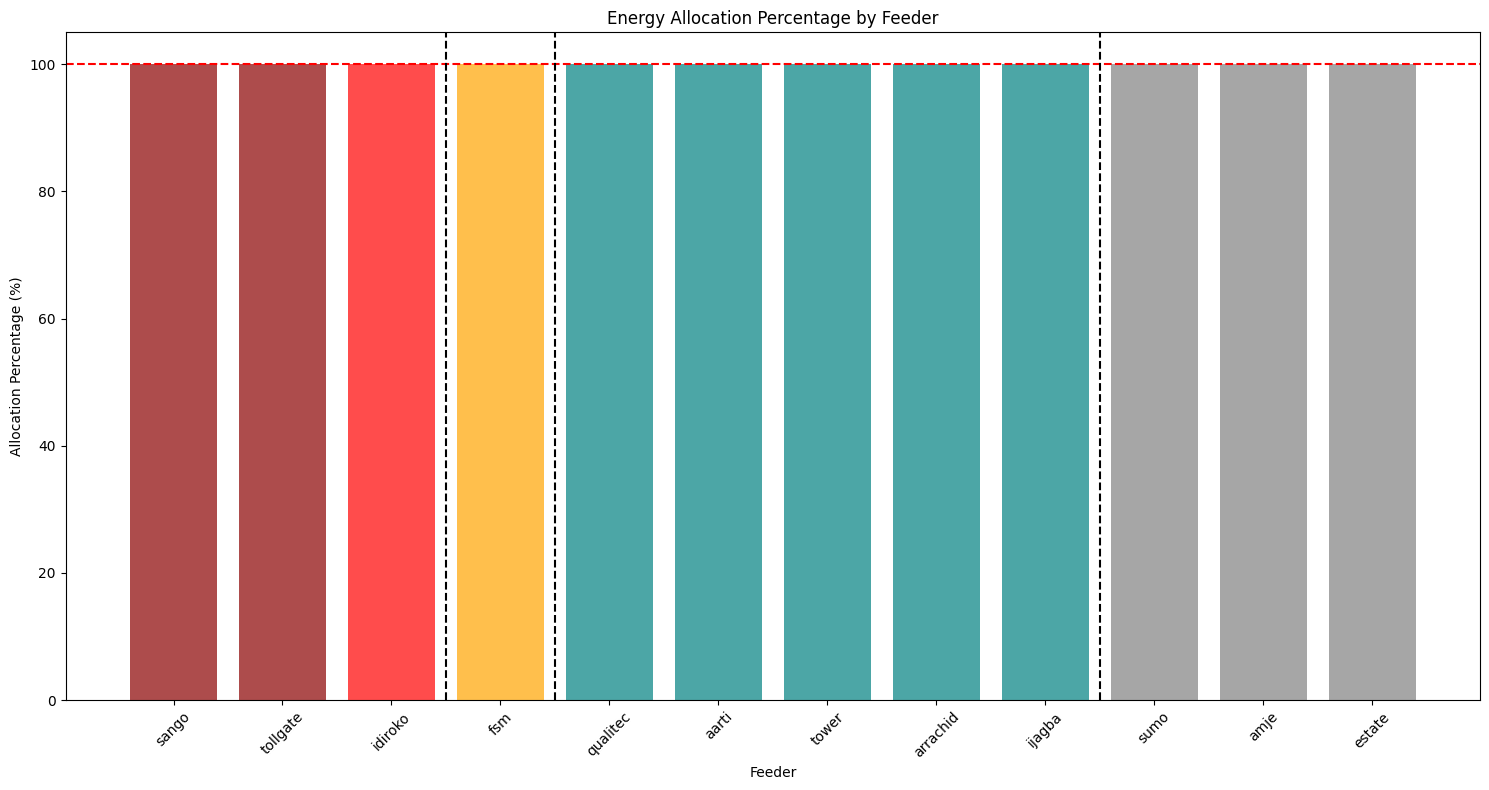

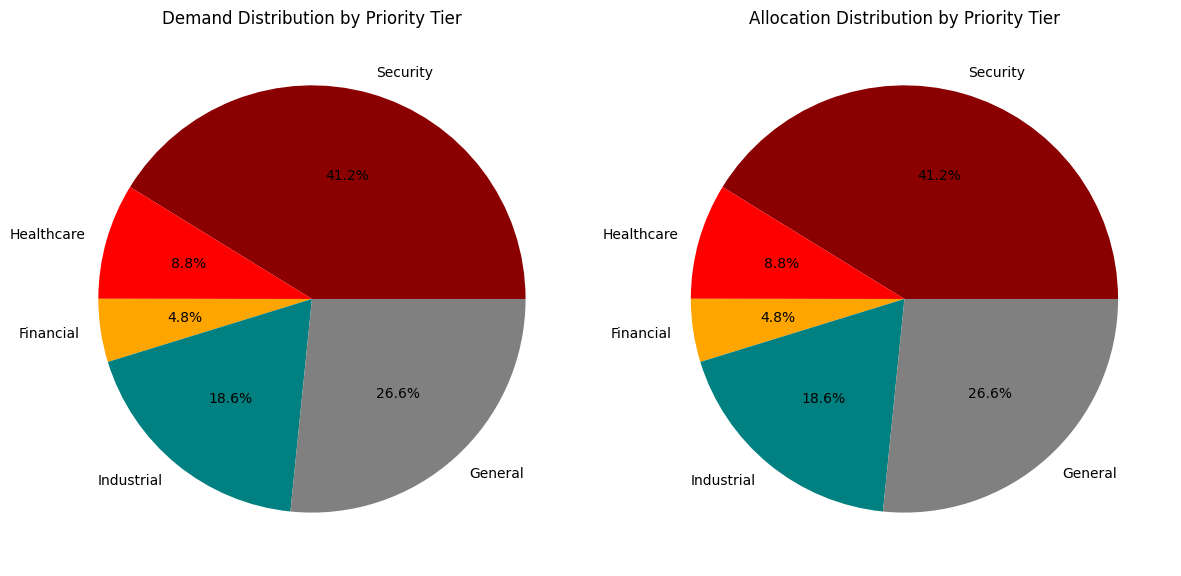


Visualizing scenario: 120% of demand (82.62 MW)


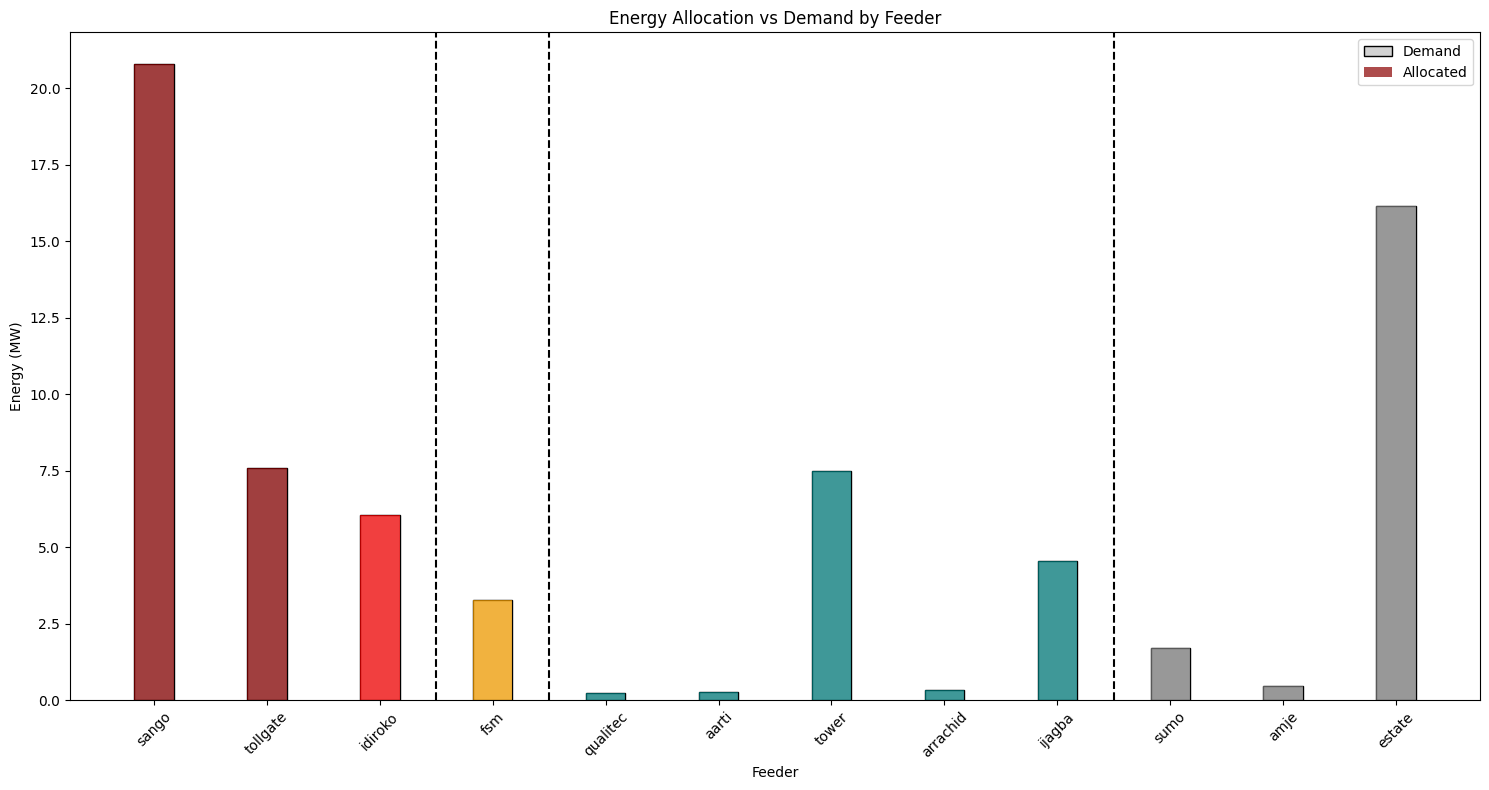

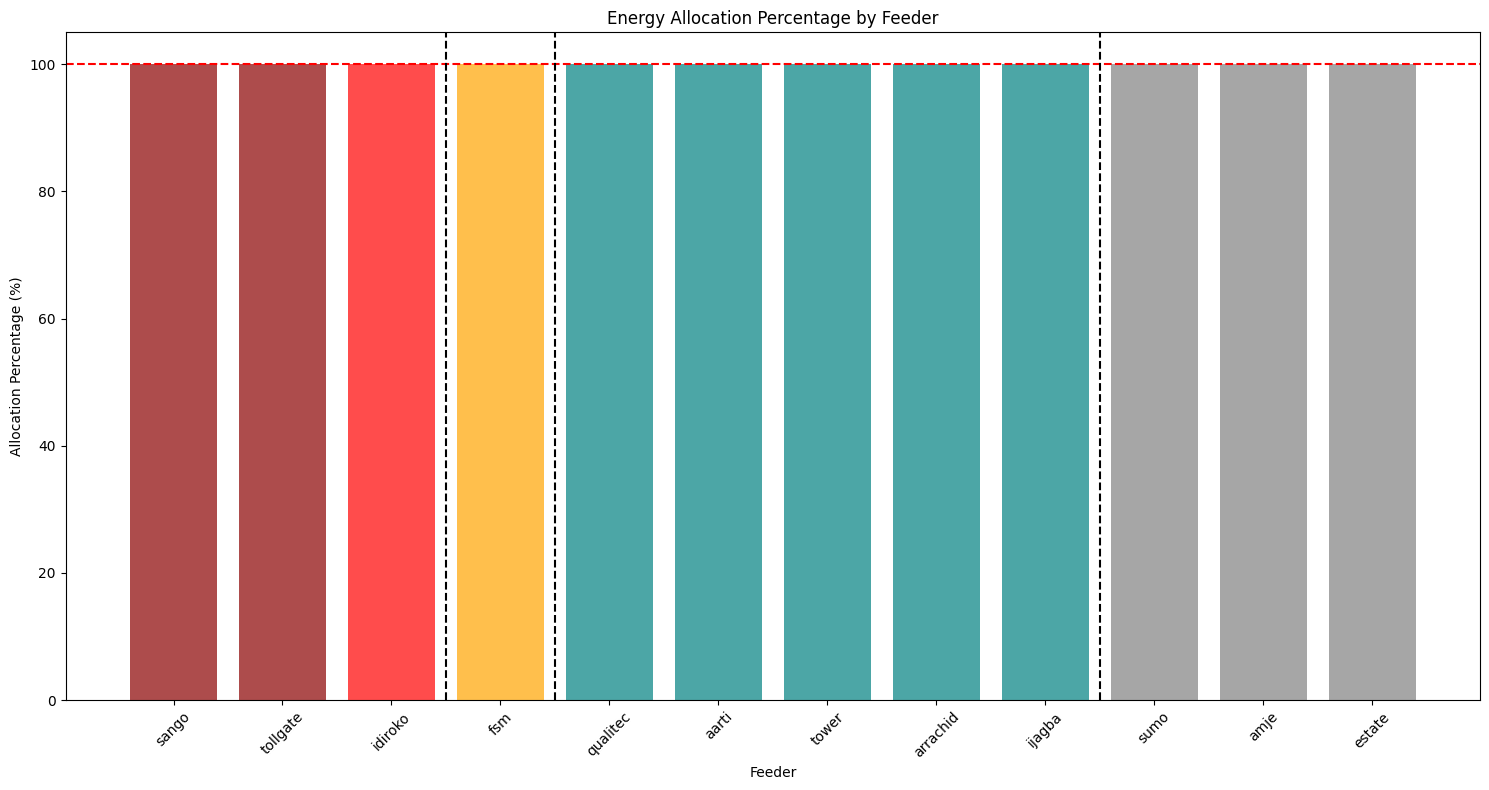

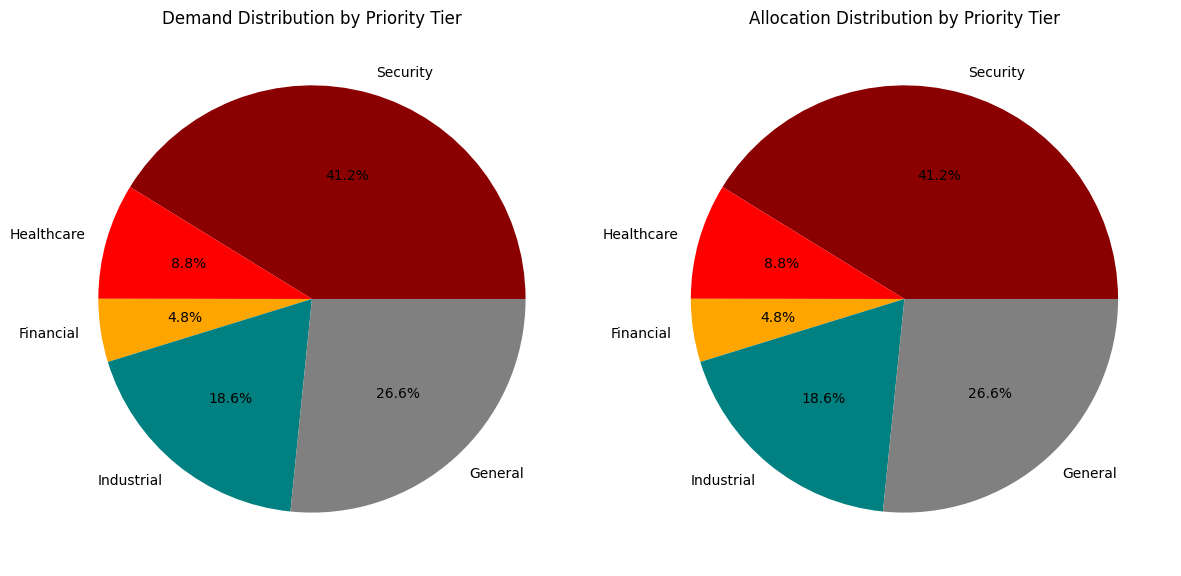

In [ ]:
# Example usage
# Assuming you have the last test sample as last_known_data
last_known_data = X_test[[5]]  # First test sample

# Run the energy management system
daily_demand, allocation = run_intelligent_energy_management(
    model,
    feature_scaler,
    target_scaler,
    last_known_data,
    feeder_cols,
    supply_variations=[-20, -10, 0, 10, 20]
)